In [1]:
import numpy as np
import pandas as pd
import torch
import torch.utils.data as td
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as colors

froot = './data/k562_small'

df = pd.read_csv(froot + ".csv")

In [2]:
print(df.head())

   seqnames     start       end strand  ensembl_gene_id  score      ctcf  \
0         6  41077441  41077441      +  ENSG00000001167    0.0 -0.074159   
1         6  41077442  41077442      +  ENSG00000001167    0.0 -0.074217   
2         6  41077443  41077443      +  ENSG00000001167    0.0 -0.074276   
3         6  41077444  41077444      +  ENSG00000001167    0.0 -0.074336   
4         6  41077445  41077445      +  ENSG00000001167    0.0 -0.074398   

   h3k36me3   h3k4me1  h3k79me2  ...       sj3       dms      rpts  wgbs  \
0 -0.347414 -0.231637  1.630302  ... -0.057178 -0.307549  0.249626   0.0   
1 -0.346807 -0.231970  1.628545  ... -0.057178 -0.307549  0.249626   0.0   
2 -0.346199 -0.232304  1.626748  ... -0.057178 -0.307549  0.249626   0.0   
3 -0.345591 -0.232638  1.624913  ... -0.057178 -0.307549  0.249626   0.0   
4 -0.344983 -0.232972  1.623041  ... -0.057178 -0.307549  0.249626   0.0   

       A         T         G         C  lambda_alphaj      zeta  
0 -0.625  1.473964 -

In [3]:
df['gene_length'] = df.groupby('ensembl_gene_id')['ensembl_gene_id'].transform('count')

In [16]:
column_names = df.columns.tolist()
feature_names = column_names[6:-7]
nucleotides = column_names[-7:-3]
print(feature_names)
print(nucleotides)

# process read counts
X_ji = df.groupby('ensembl_gene_id')['score'].apply(list).tolist() 

# process GLM simulated elongation rates
Z_ji = df.groupby('ensembl_gene_id')['zeta'].apply(list).tolist() 

num_samples = len(X_ji)
print(num_samples)

['ctcf', 'h3k36me3', 'h3k4me1', 'h3k79me2', 'h3k9me1', 'h3k9me3', 'h4k20me1', 'sj5', 'sj3', 'dms', 'rpts', 'wgbs']
['A', 'T', 'G', 'C']
1502


In [77]:
from sklearn.preprocessing import MinMaxScaler

#Y_ji is a list of samples containing lists of their feature values
    # [   
    #   [[sample_1_feature_1], [sample_1_feature_2], [sample_1_feature_3]],
    #   [[sample_2_feature_1], [sample_1_feature_2], [sample_1_feature_3]],  
    # ]

Y_ji = []

for sample_id in df['ensembl_gene_id'].unique():
    sample_data = [df[feature_name][df['ensembl_gene_id'] == sample_id].tolist() for feature_name in feature_names]
    Y_ji.append(sample_data)

In [7]:
# normalize features
#scaler = MinMaxScaler()
#Y_ji = np.array(Y_ji)
# reshape dataset to [num_samples, num_features * feature_length]
#Y_ji_reshaped = Y_ji.reshape(Y_ji.shape[0], -1)
#normalized_Y_ji_reshaped = scaler.fit_transform(Y_ji_reshaped)
#Y_ji = normalized_Y_ji_reshaped.reshape(Y_ji.shape)

In [5]:
C_j = df.groupby('ensembl_gene_id')['lambda_alphaj'].apply(list).tolist() 

In [6]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

class CustomDataset(Dataset):
    def __init__(self, X_ji, C_j, Z_ji):
        self.X_ji = X_ji
        self.C_j = C_j
        self.Z_ji = Z_ji

    def __len__(self):
        return len(self.X_ji)

    def __getitem__(self, idx):
        return {
            'X_ji': torch.tensor(self.X_ji[idx], dtype=torch.float32),
            'C_j': torch.tensor(self.C_j[idx], dtype=torch.float32),
            'Z_ji': torch.tensor(self.Z_ji[idx], dtype=torch.float32)
        }

In [7]:
dataset = CustomDataset(X_ji, C_j, Z_ji)

trnset, valset, tstset = td.random_split(dataset, [0.5,0.25,0.25])

trndl = DataLoader(trnset, batch_size=64, shuffle=True)
tstdl = DataLoader(tstset, batch_size=64, shuffle=False)
valdl = DataLoader(valset, batch_size=64, shuffle=False)

Model(
  (lstm_layers): ModuleList(
    (0): LSTM(200, 64, batch_first=True)
    (1-9): 9 x LSTM(64, 64, batch_first=True)
  )
  (layer_norms): ModuleList(
    (0-9): 10 x LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (fc): Linear(in_features=64, out_features=200, bias=True)
)
torch.Size([64, 200])
Number of parameters: 381896


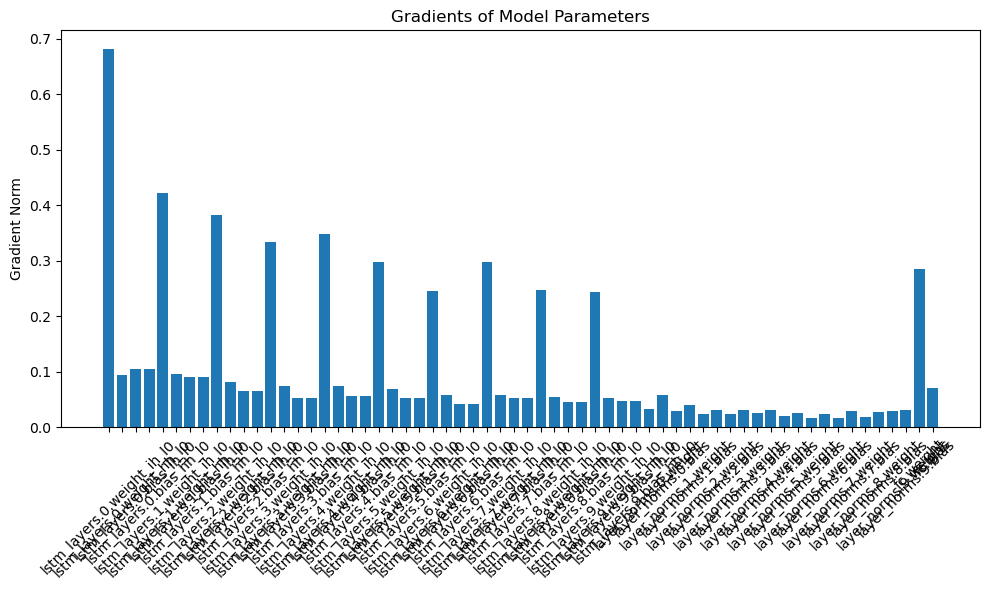

In [41]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init

class Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_lstm_layers):
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.lstm_layers = nn.ModuleList([nn.LSTM(input_size=input_size if i == 0 else hidden_size,
                                                  hidden_size=hidden_size,
                                                  num_layers=1,  # Use single-layer LSTMs in the stack
                                                  batch_first=True) for i in range(num_lstm_layers)])
    
        self.layer_norms = nn.ModuleList([nn.LayerNorm(hidden_size) for _ in range(num_lstm_layers)])
    
        for lstm_layer in self.lstm_layers:
            # Apply Xavier initialization to LSTM weights
            for param in lstm_layer.parameters():
                if len(param.shape) >= 2:
                    init.xavier_uniform_(param)

        self.fc = nn.Linear(hidden_size, input_size)
        init.xavier_uniform_(self.fc.weight)
    
    def forward(self, x):
        for i, lstm_layer in enumerate(self.lstm_layers):
            x, _ = lstm_layer(x)
            x = self.layer_norms[i](x)
        hidden_outputs = F.relu(x) 
        predictions = self.fc(hidden_outputs)
        return predictions

# input size: [50, 12, 2000]
input_size = 200
hidden_size = 64
num_lstm_layers = 10 

model = Model(input_size, hidden_size, num_lstm_layers)
print(model)

arr = torch.randn((64,200))
print(model(arr).shape)
nparm = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: " + str(nparm))

output = model(arr)

# Compute gradients
output.mean().backward()

# Plot gradients
gradient_list = []
parameter_names = []

for name, param in model.named_parameters():
    if param.grad is not None:
        gradient_list.append(param.grad.norm().item())
        parameter_names.append(name)

plt.figure(figsize=(10, 6))
plt.bar(parameter_names, gradient_list)
plt.ylabel('Gradient Norm')
plt.title('Gradients of Model Parameters')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, X_ji, C_j, Z_ji):
        loss = X_ji * Z_ji + C_j * torch.exp(-Z_ji)
        # compute mean over batch to normalize due to varying batch sizes
        return loss.mean() 

In [72]:
def plot_data(targets, outputs):
    indices = range(len(targets[0]))

    fig, axs = plt.subplots(3, 3, figsize=(15,15))
    for i in range(3):
        for j in range(3):
            axs[i, j].scatter(indices, targets[i+j*3], s=5)
            axs[i, j].scatter(indices, outputs.detach().numpy()[i+j*3], s=5)
            axs[i, j].set_ylim(0.4, 1.3)

    plt.xlabel('Index')
    plt.ylabel('Elongation Rates')
    plt.legend(['GLM Elongation Rate', 'NN Elongation Rate'], loc='upper center', bbox_to_anchor=(0.5, -0.6))


Epoch 1
Epoch 1 trn_loss: 0.0022 val_loss: 0.0023
Epoch 2
Epoch 2 trn_loss: 0.0022 val_loss: 0.0023
Epoch 3
Epoch 3 trn_loss: 0.0022 val_loss: 0.0023
Epoch 4
Epoch 4 trn_loss: 0.0022 val_loss: 0.0023
Epoch 5
Epoch 5 trn_loss: 0.0022 val_loss: 0.0023
Epoch 6
Epoch 6 trn_loss: 0.0022 val_loss: 0.0023
Epoch 7
Epoch 7 trn_loss: 0.0022 val_loss: 0.0023
Epoch 8
Epoch 8 trn_loss: 0.0022 val_loss: 0.0023
Epoch 9
Epoch 9 trn_loss: 0.0022 val_loss: 0.0023
Epoch 10
Epoch 10 trn_loss: 0.0022 val_loss: 0.0023
Epoch 11
Epoch 11 trn_loss: 0.0022 val_loss: 0.0023
Epoch 12
Epoch 12 trn_loss: 0.0022 val_loss: 0.0023
Epoch 13
Epoch 13 trn_loss: 0.0021 val_loss: 0.0022
Epoch 14
Epoch 14 trn_loss: 0.0022 val_loss: 0.0023
Epoch 15
Epoch 15 trn_loss: 0.0022 val_loss: 0.0023
Epoch 16
Epoch 16 trn_loss: 0.0022 val_loss: 0.0023
Epoch 17
Epoch 17 trn_loss: 0.0022 val_loss: 0.0023
Epoch 18
Epoch 18 trn_loss: 0.0021 val_loss: 0.0022
Epoch 19
Epoch 19 trn_loss: 0.0021 val_loss: 0.0022
Epoch 20
Epoch 20 trn_loss: 0.

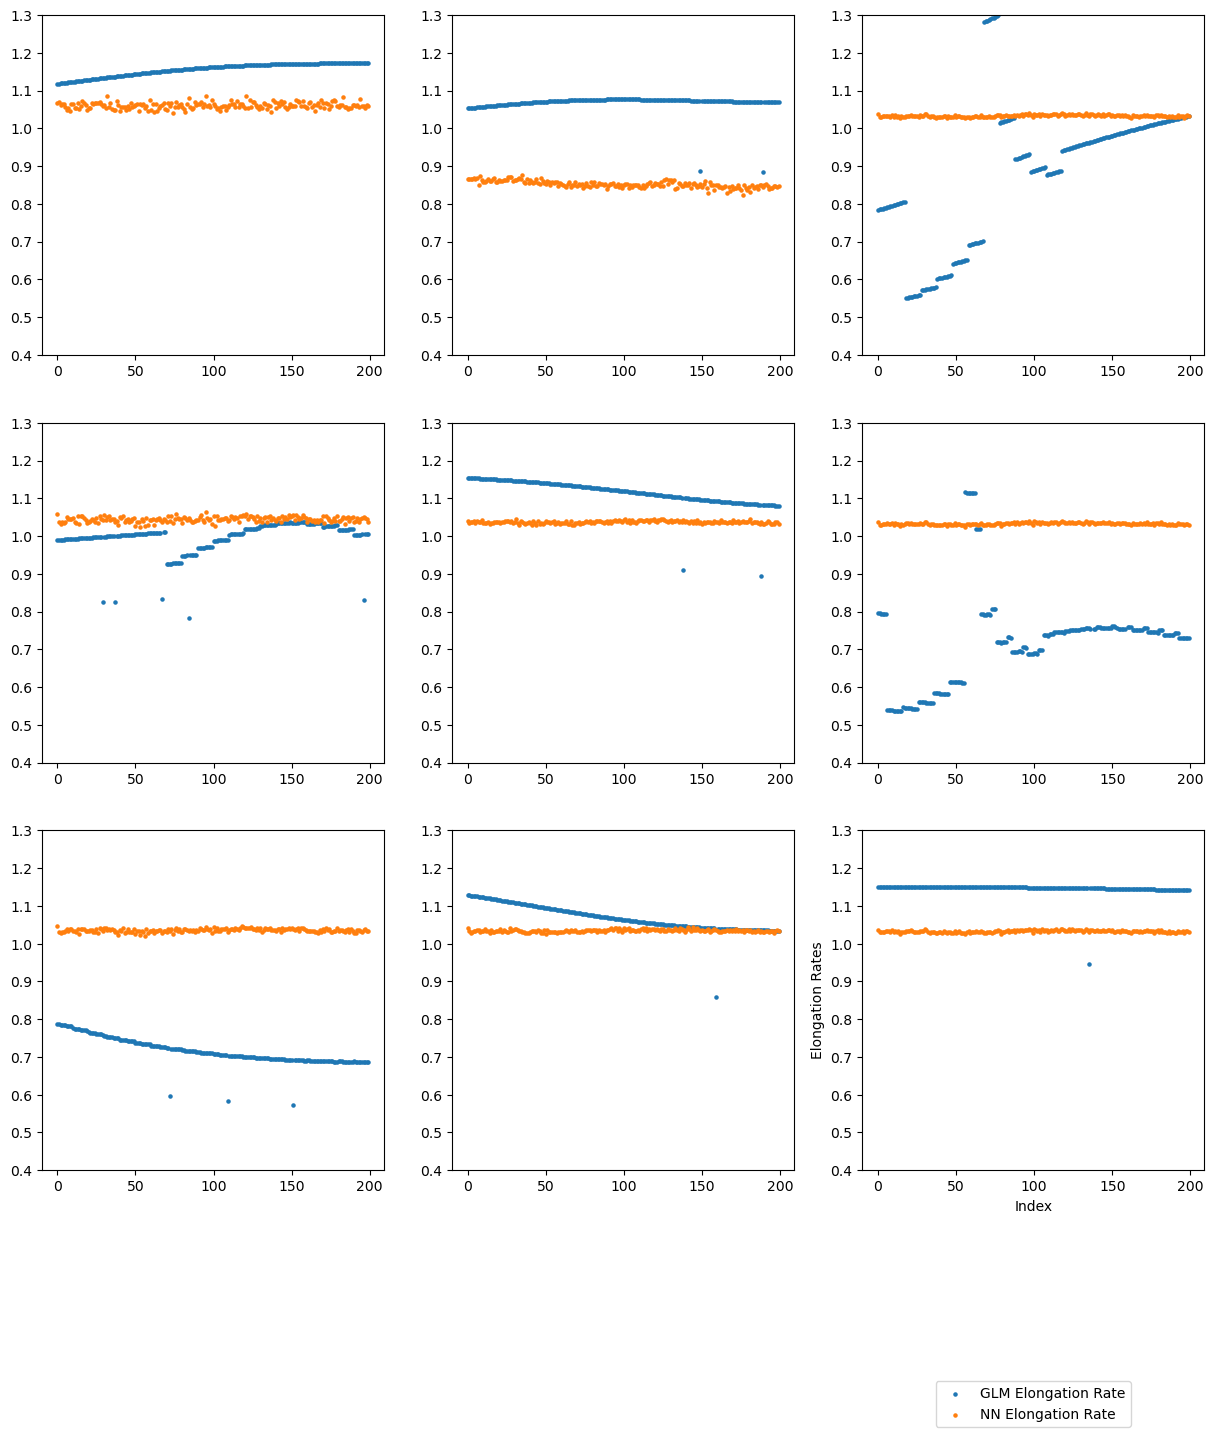

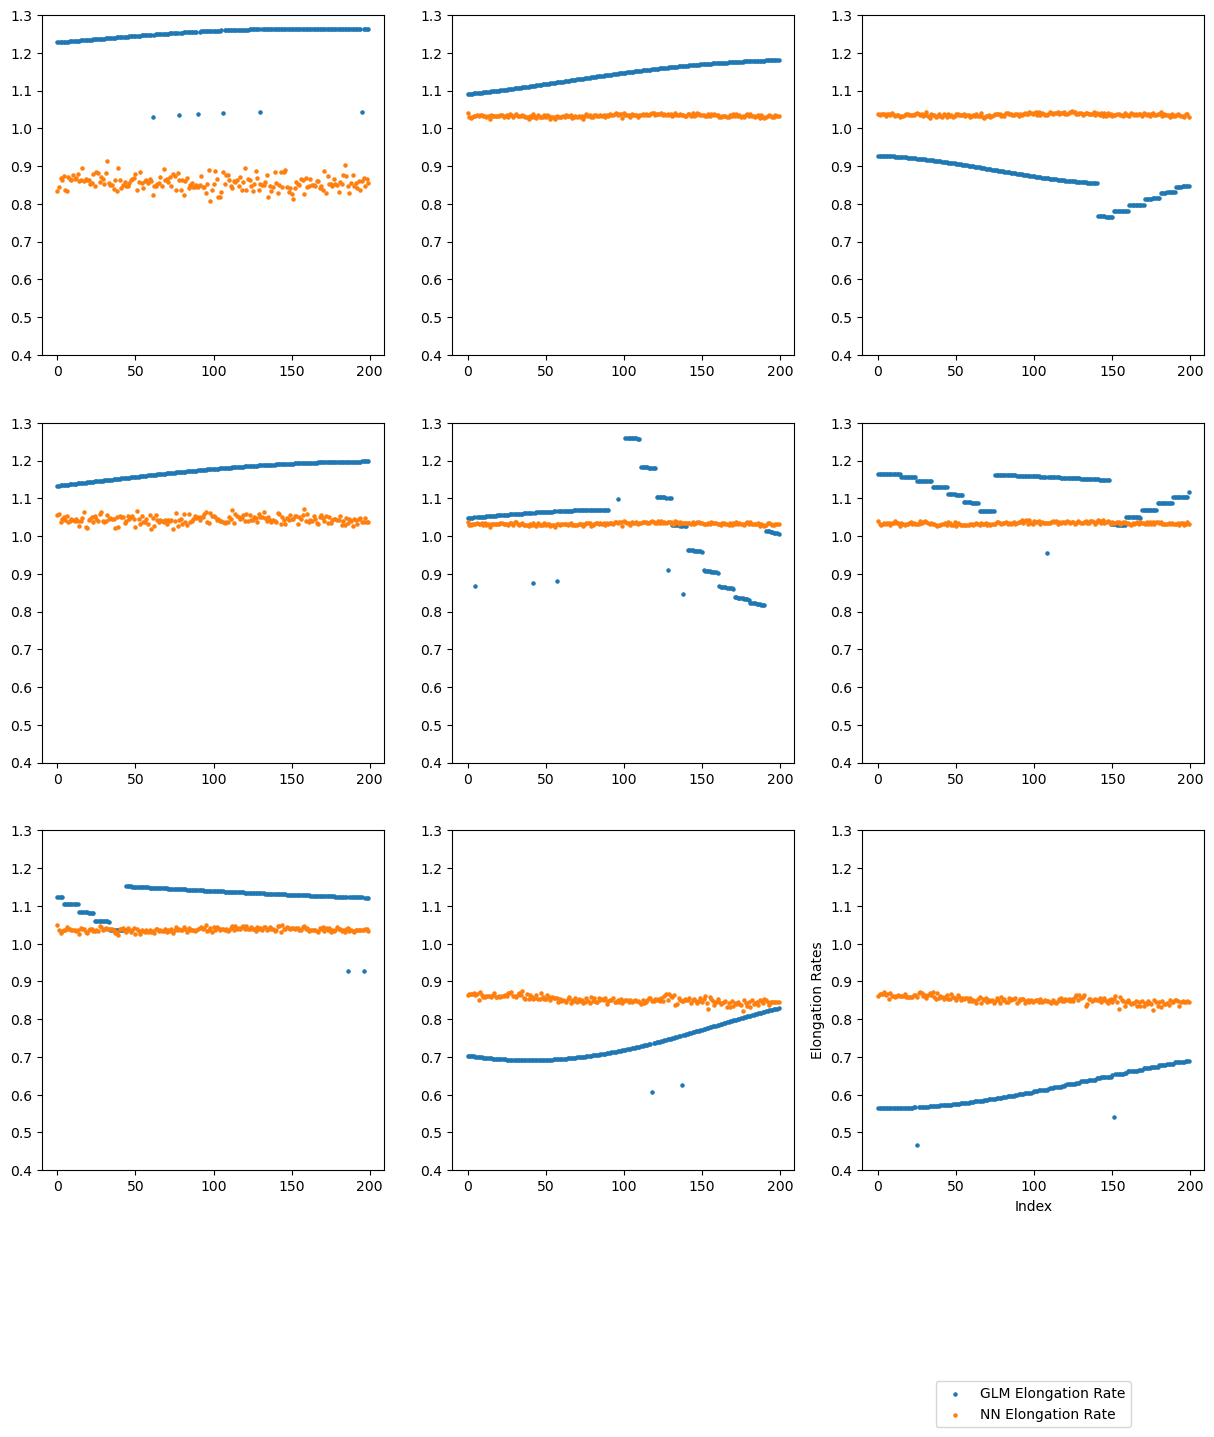

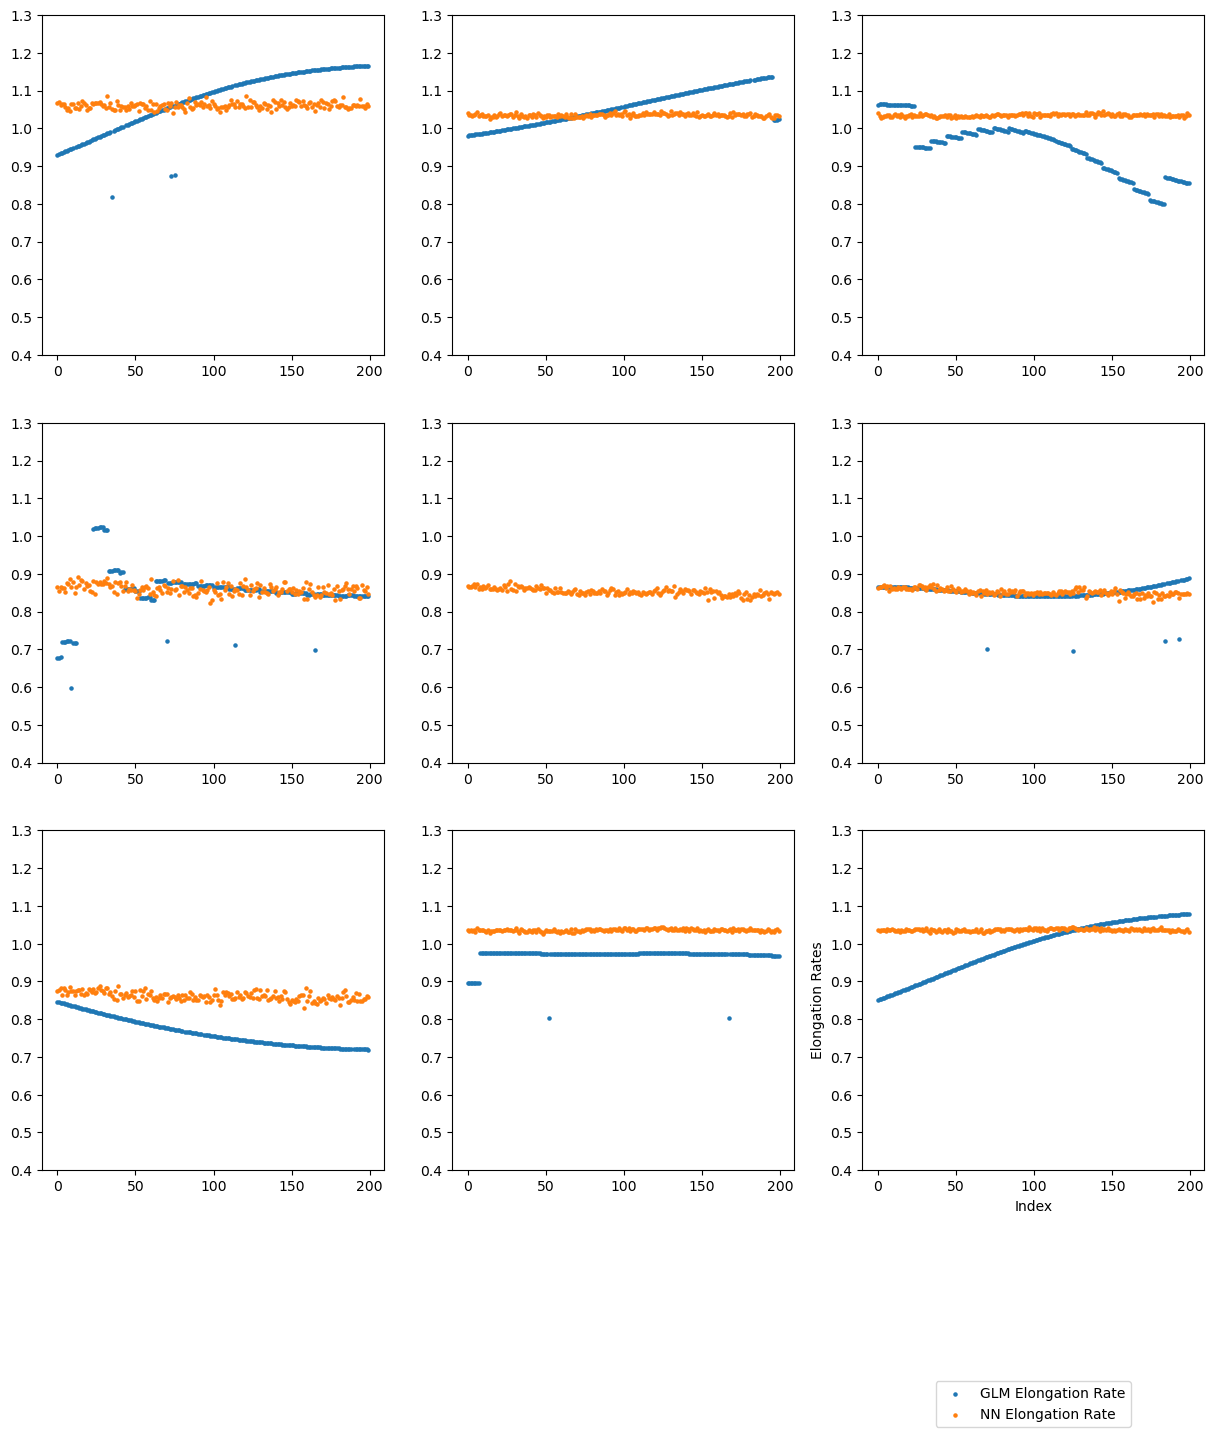

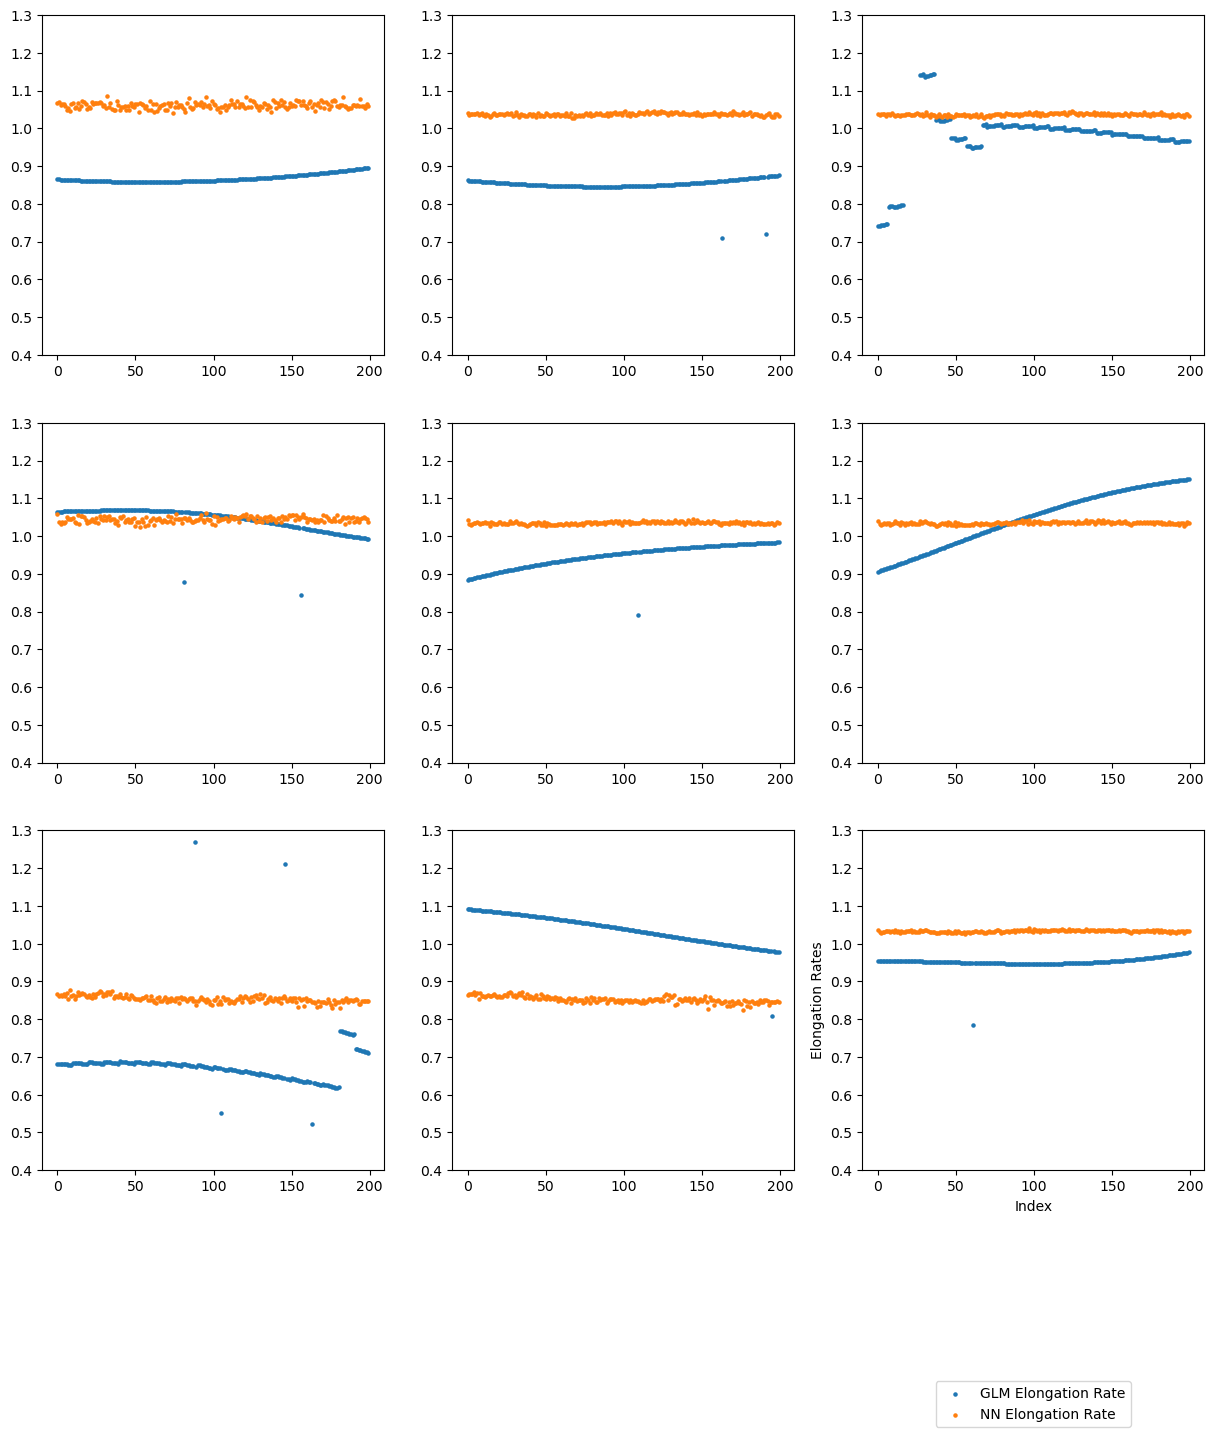

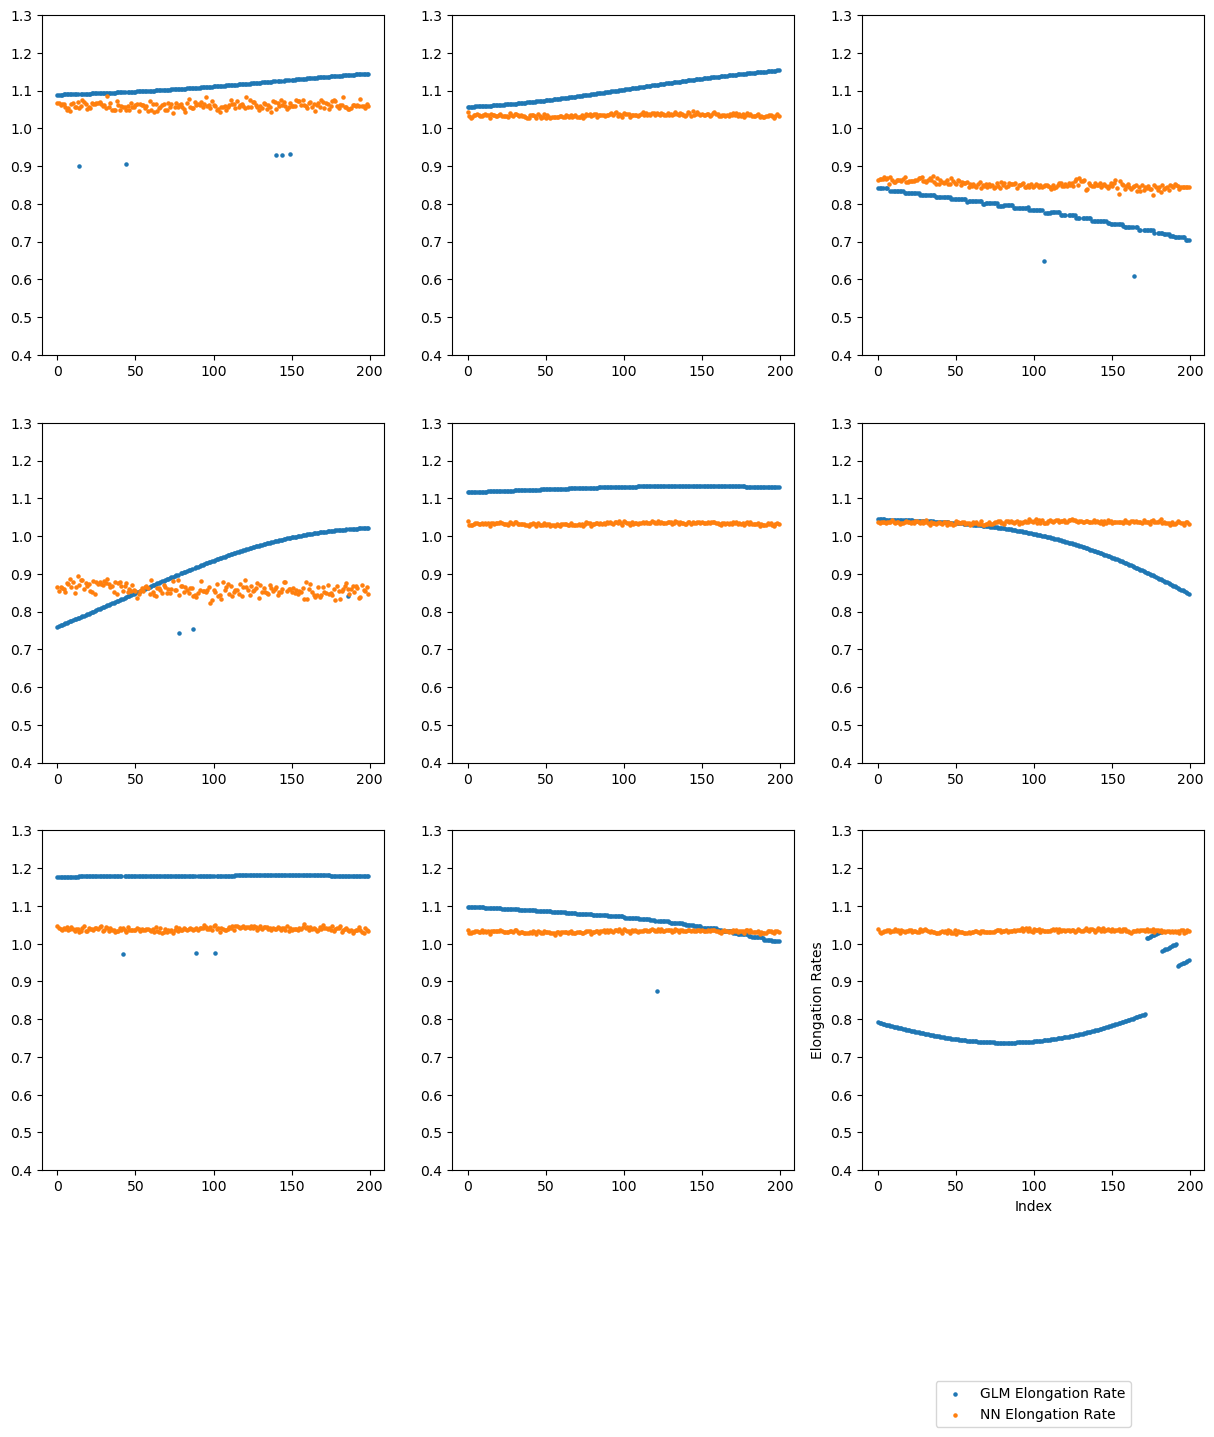

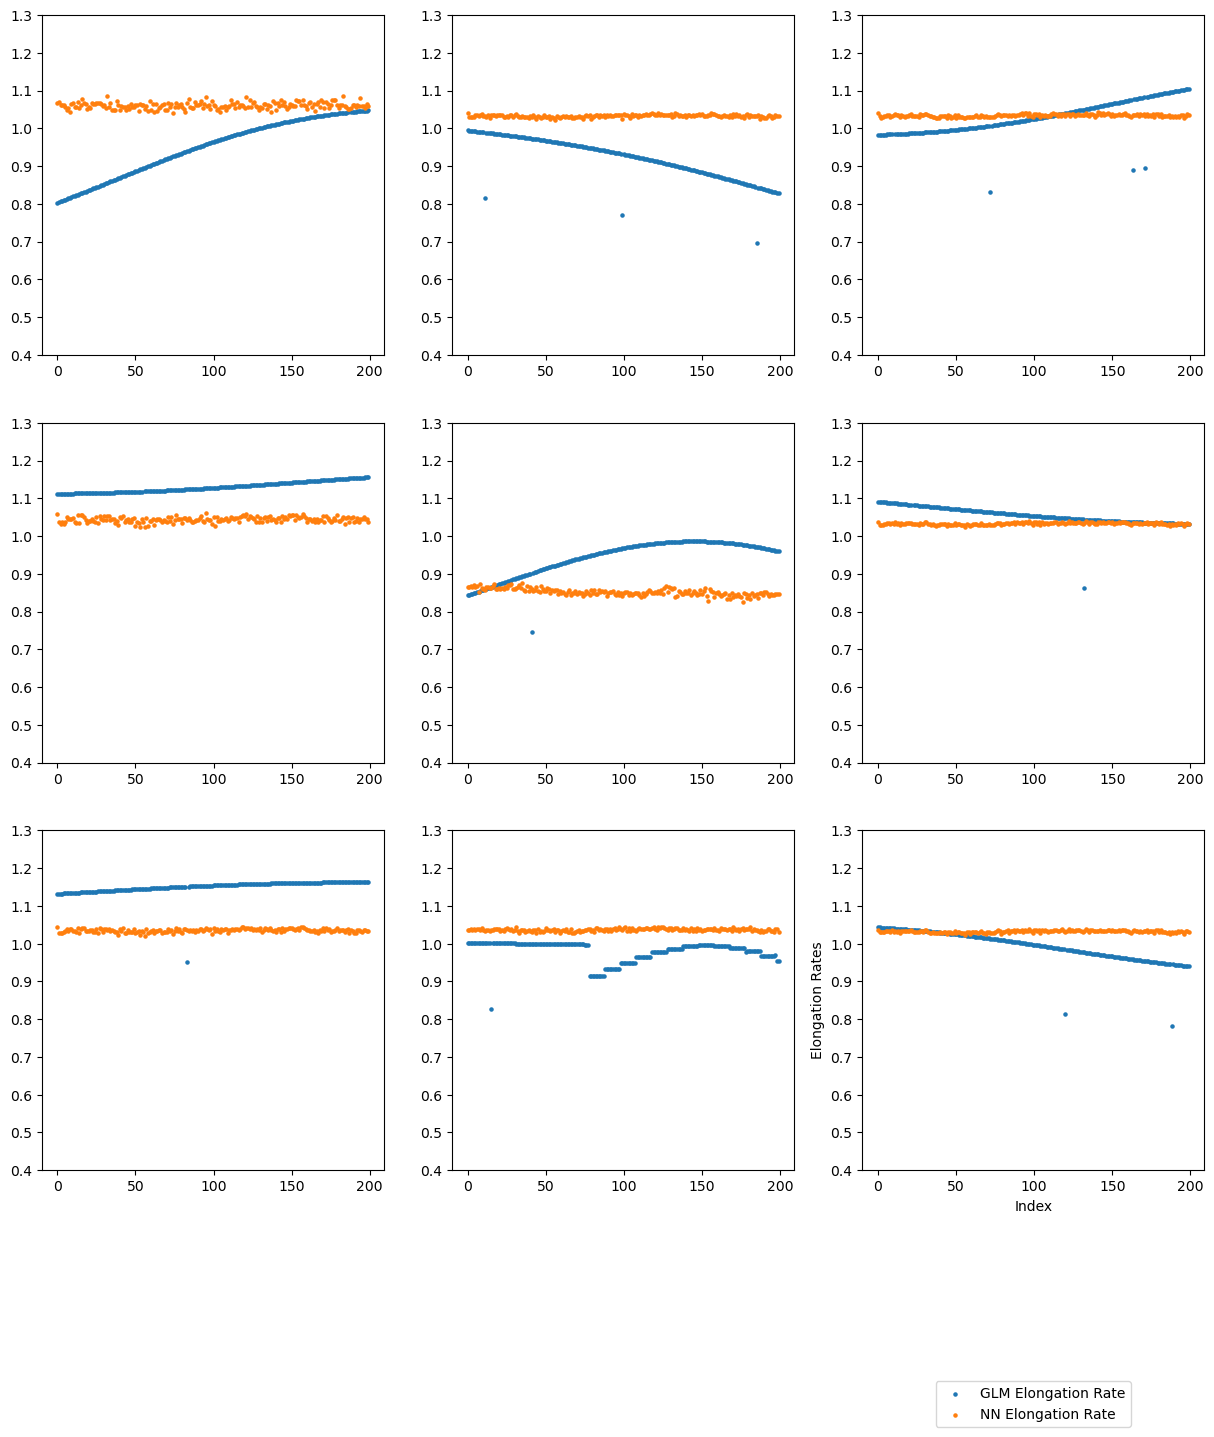

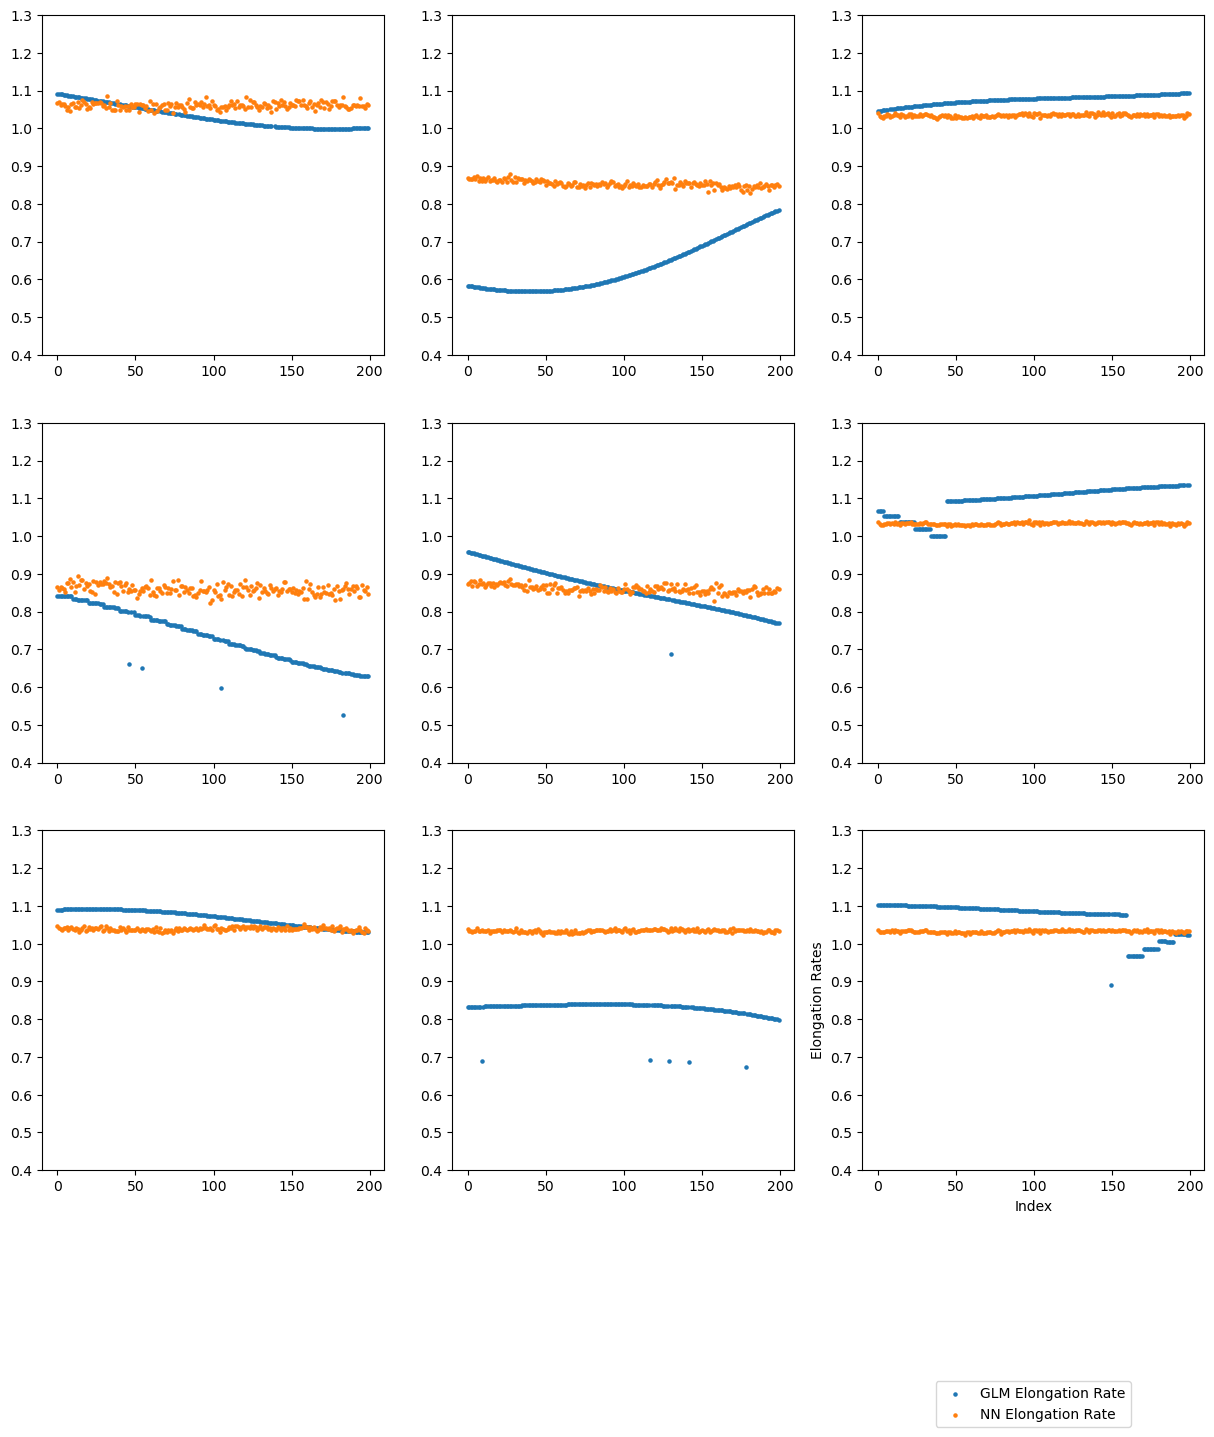

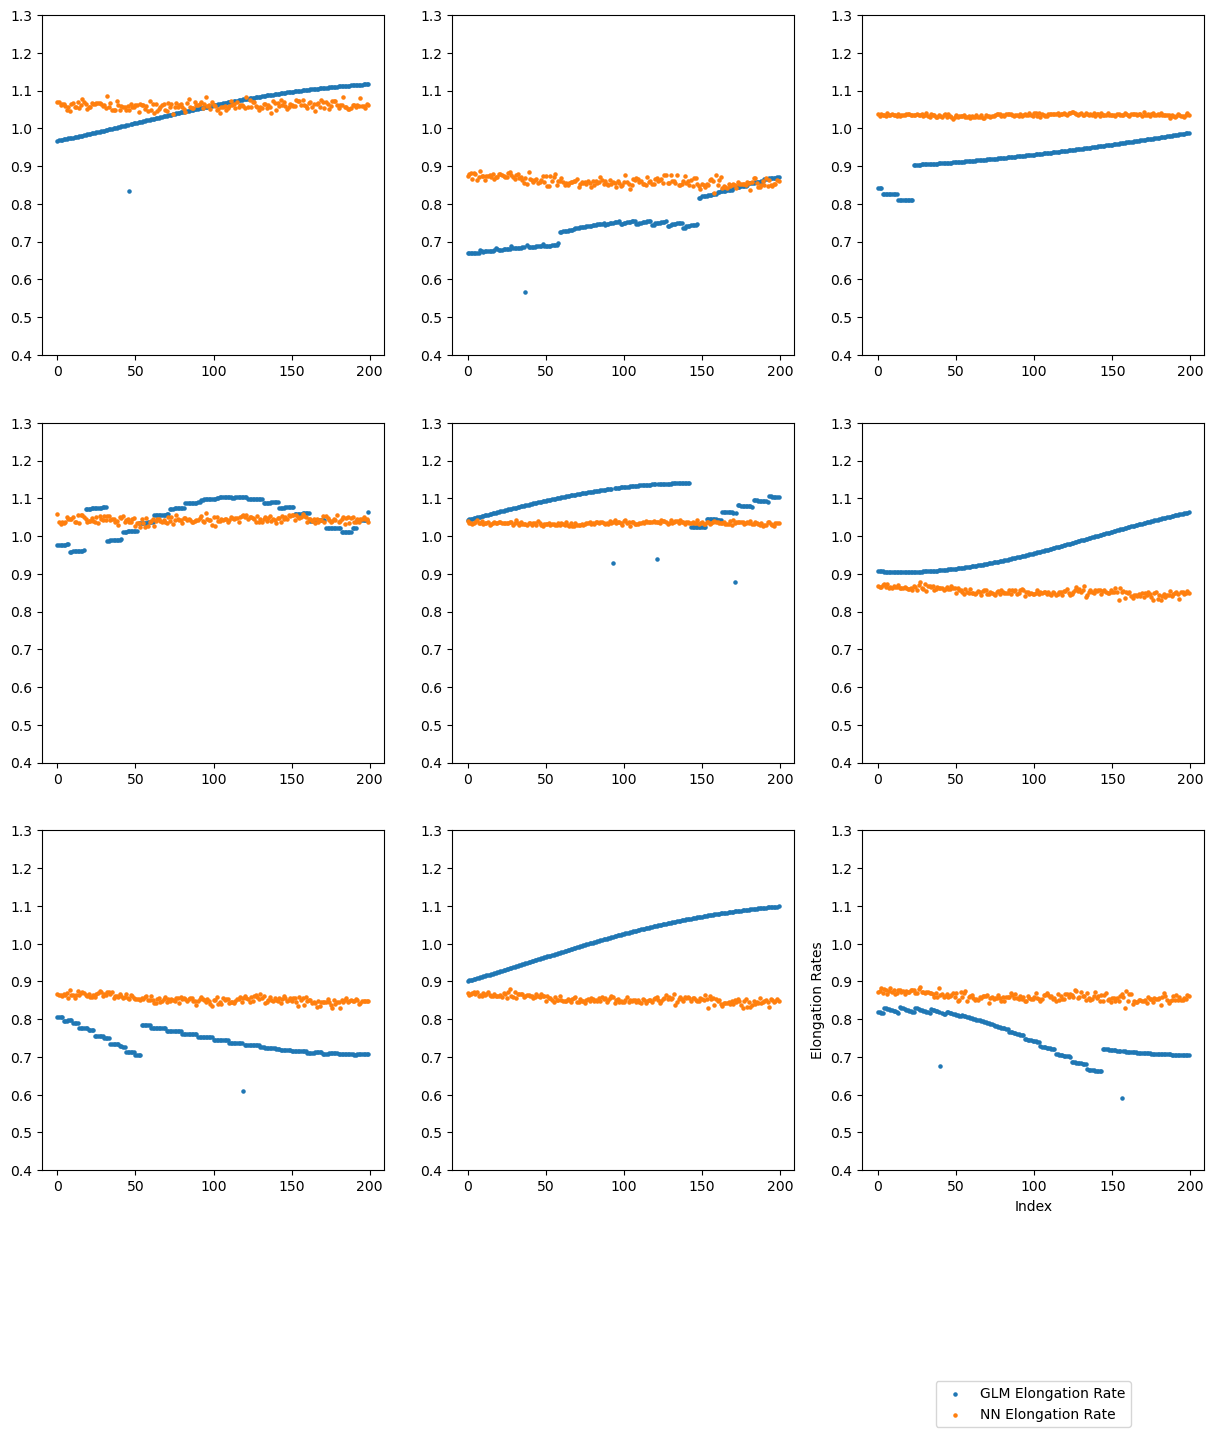

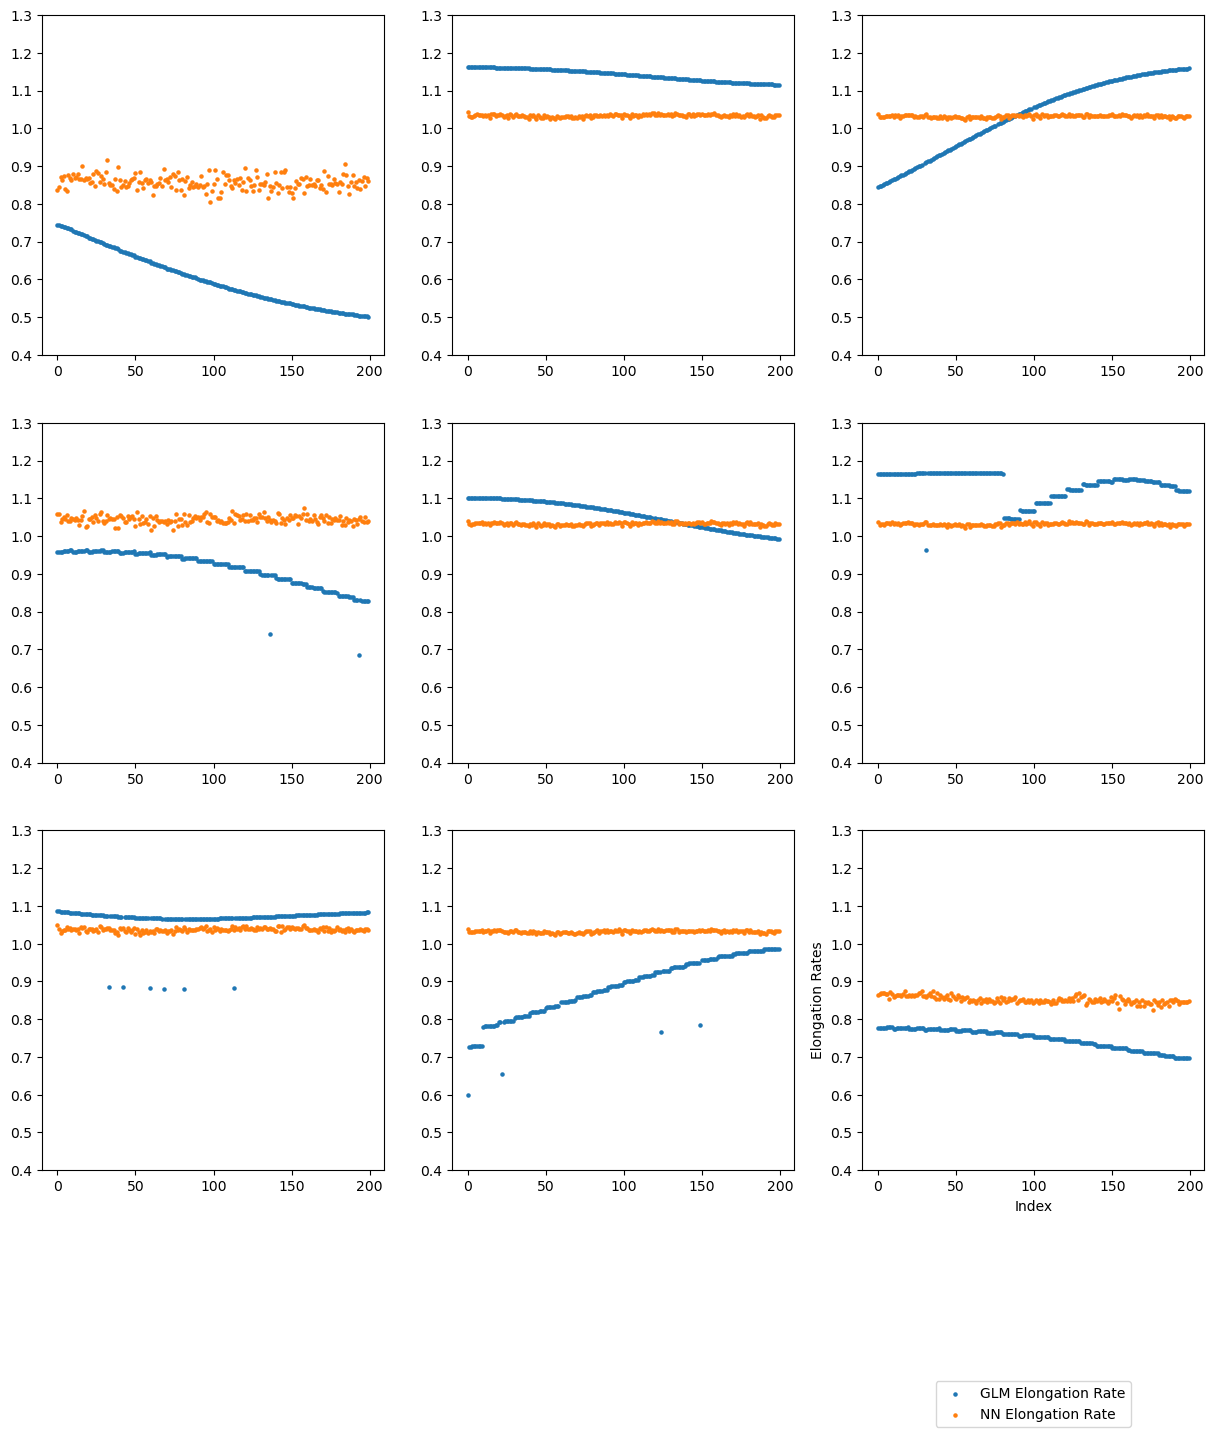

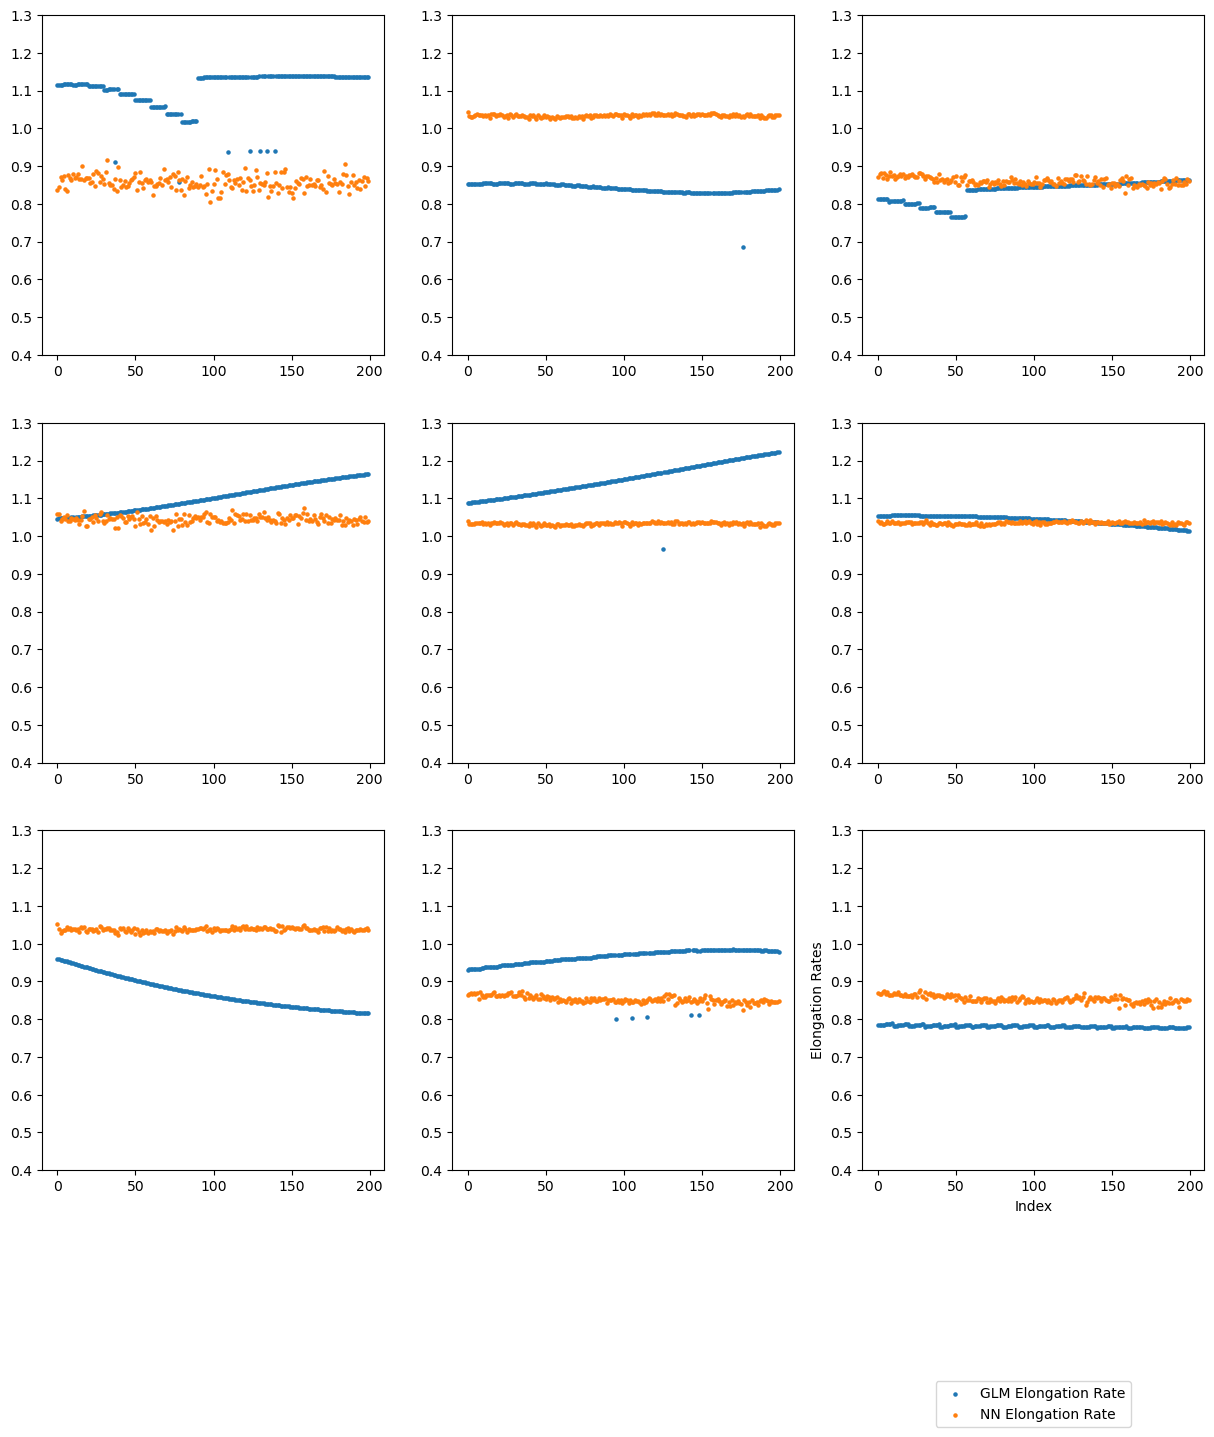

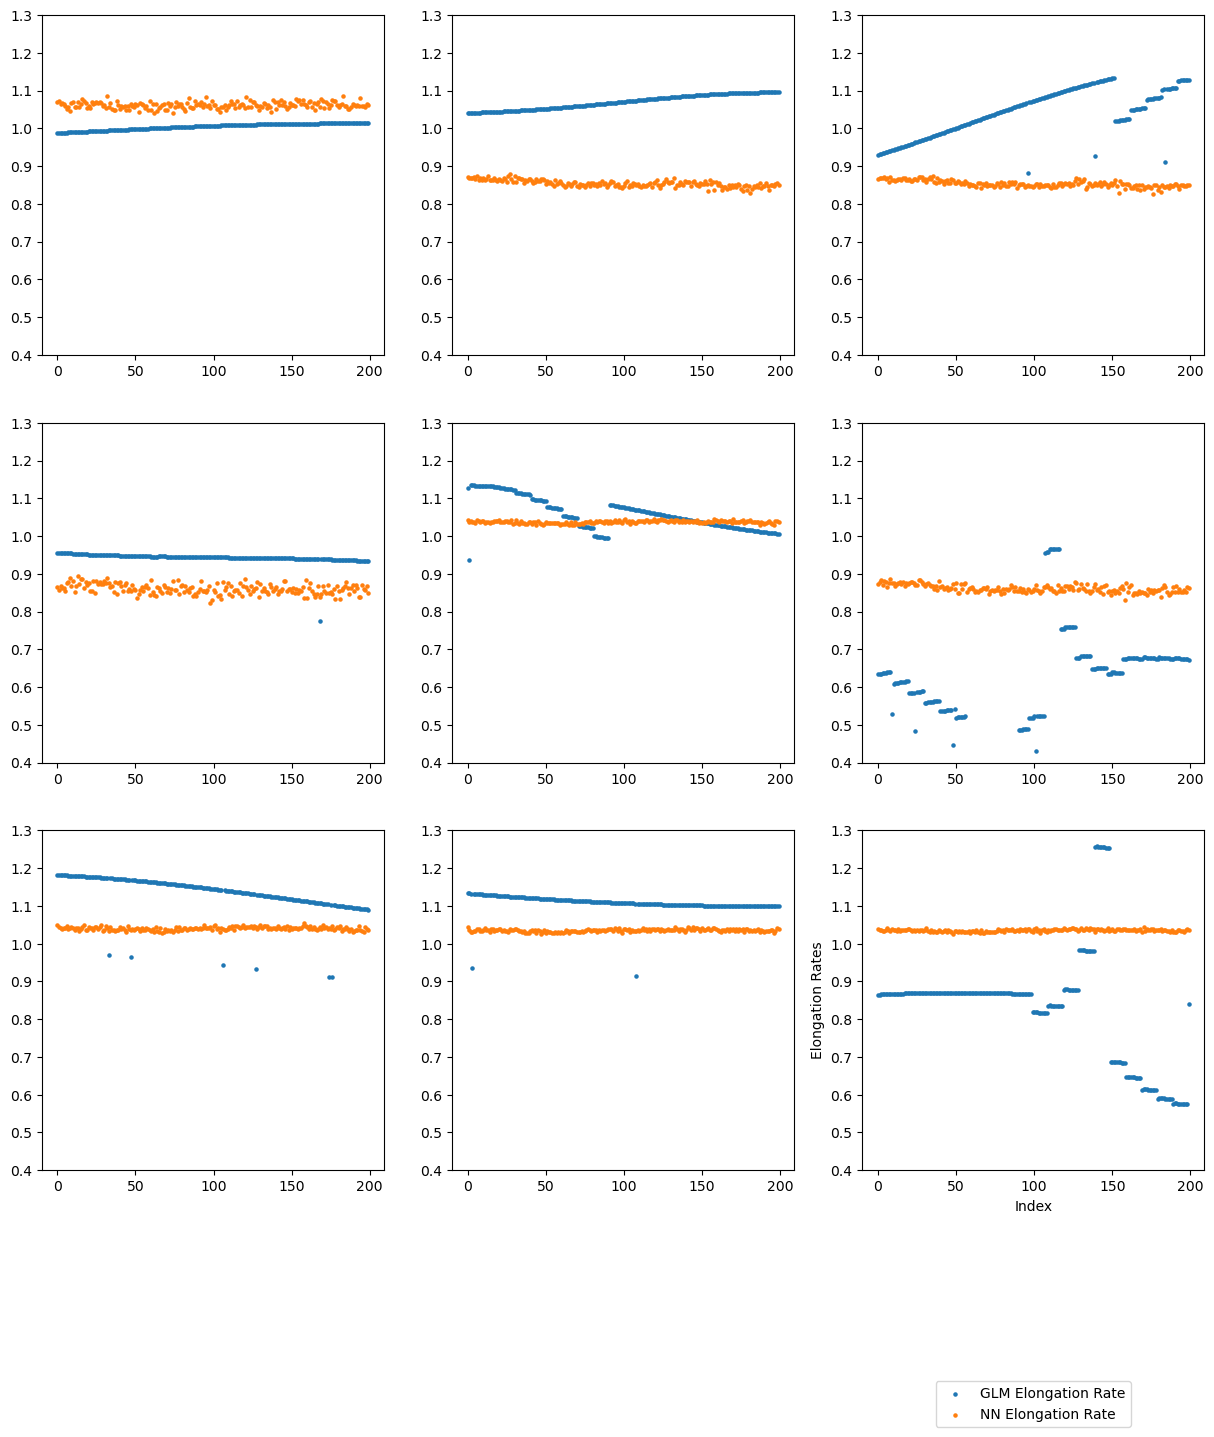

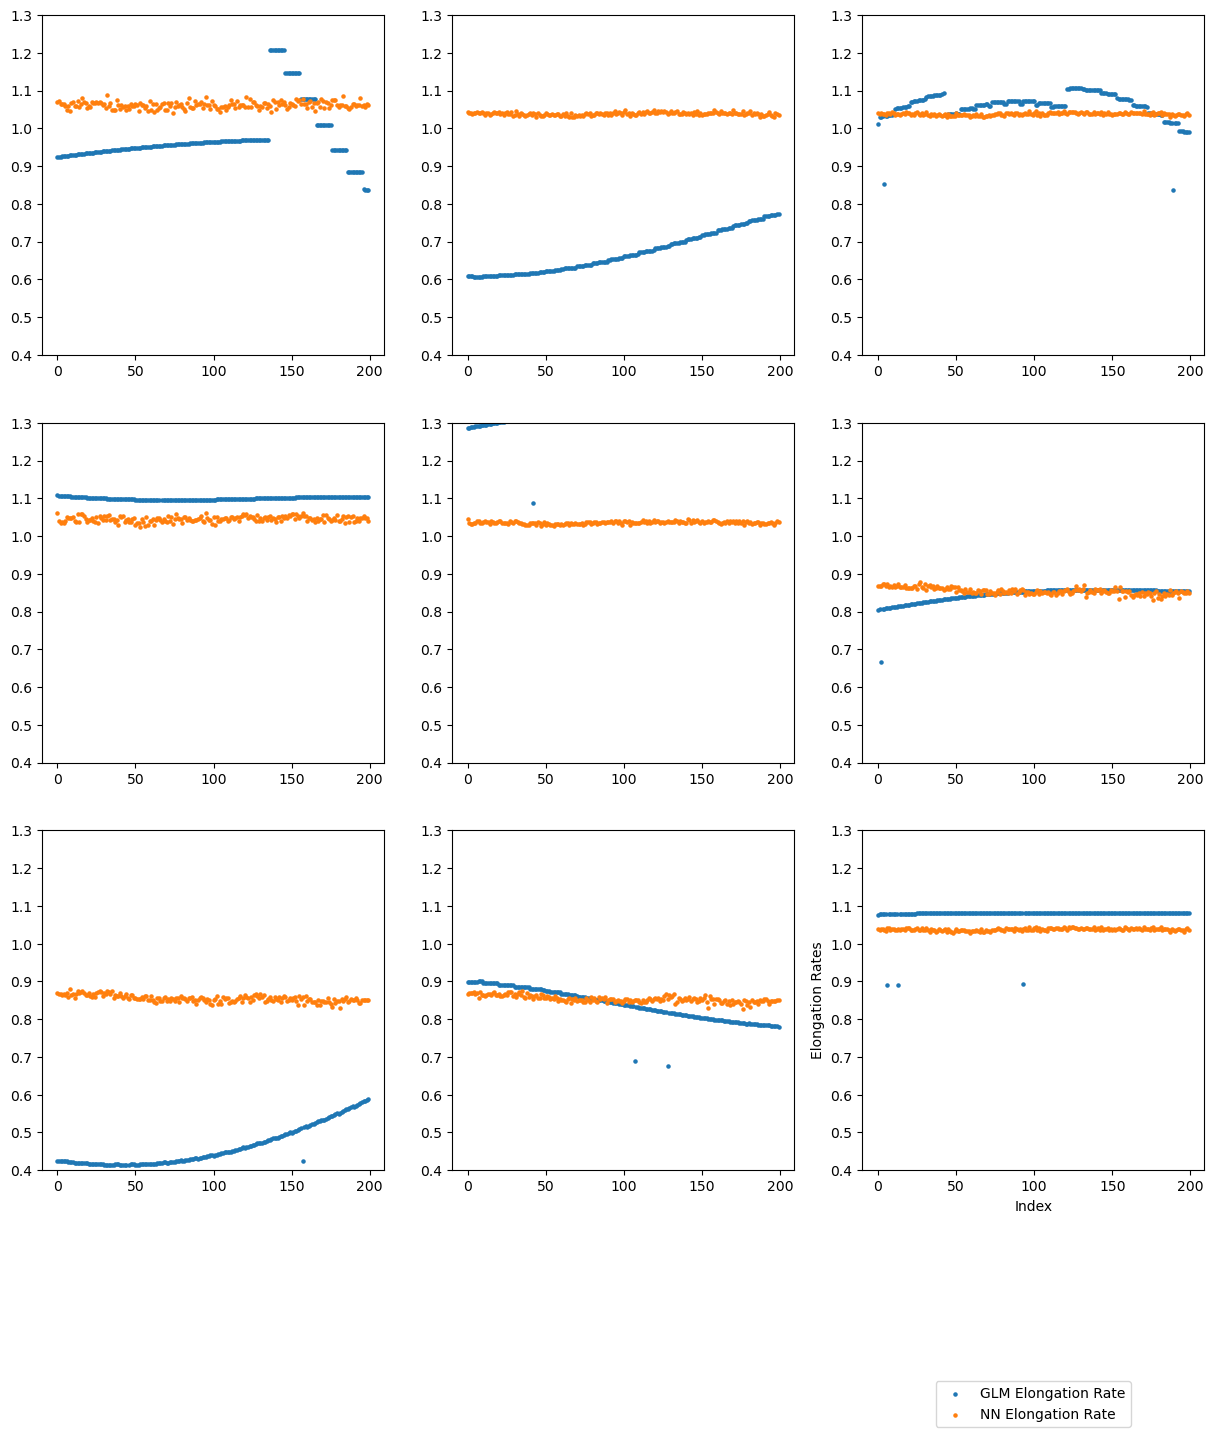

In [73]:
import torch.optim.lr_scheduler as lr_scheduler

optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


num_epochs = 50

loss_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs

loss_fn = nn.L1Loss()#nn.MSELoss()#CustomLoss()

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}')
    model.train()
    for batch in trndl:
        optimizer.zero_grad()
        X_ji_batch = batch['X_ji']
        C_j_batch = batch['C_j']
        outputs = model(X_ji_batch)
        #loss = loss_fn(X_ji_batch, C_j_batch, outputs)
        loss = loss_fn(outputs, batch['Z_ji'])
        loss.backward()
        optimizer.step()
        loss_hist_train[epoch] += loss.item()
        if epoch == 49:
            plot_data(batch['Z_ji'], outputs)
    loss_hist_train[epoch] /= len(trndl.dataset)
    scheduler.step()
    
    model.eval()
    with torch.no_grad():
        for batch in valdl:
            X_ji_batch = batch['X_ji']
            C_j_batch = batch['C_j']
            outputs = model(X_ji_batch)
            #loss = loss_fn(X_ji_batch, C_j_batch, outputs)
            loss = loss_fn(outputs, batch['Z_ji'])
            loss_hist_valid[epoch] += loss.item()
        loss_hist_valid[epoch] /= len(valdl.dataset)
    
    print(f'Epoch {epoch+1} trn_loss: '
          f'{loss_hist_train[epoch]:.4f} val_loss: '
          f'{loss_hist_valid[epoch]:.4f}')

<function matplotlib.pyplot.show(close=None, block=None)>

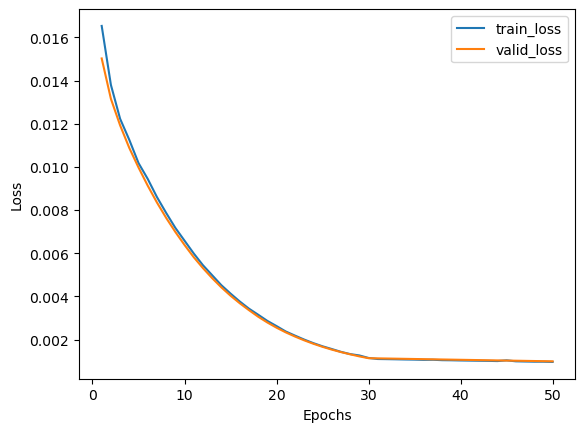

In [43]:
from matplotlib import pyplot as plt
epochs = range(1, len(loss_hist_train) + 1)
plt.plot(epochs, loss_hist_train, label='train_loss')
plt.plot(epochs, loss_hist_valid, label='valid_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show 

In [62]:
for batch in tstdl:
    outputs = model(batch['X_ji'])
    print(outputs)
    print(len(outputs))

tensor([[0.8627, 0.7505, 0.8784,  ..., 0.6215, 0.6404, 0.8869],
        [0.9410, 0.6990, 0.9051,  ..., 0.6273, 0.6023, 0.8866],
        [0.9785, 0.6733, 0.9129,  ..., 0.6310, 0.5751, 0.8880],
        ...,
        [0.9684, 0.6672, 0.9027,  ..., 0.6954, 0.5493, 0.9535],
        [0.9684, 0.6676, 0.9027,  ..., 0.6953, 0.5494, 0.9532],
        [0.9681, 0.6677, 0.9037,  ..., 0.6947, 0.5497, 0.9540]],
       grad_fn=<AddmmBackward0>)
64
tensor([[0.9015, 0.7056, 0.9383,  ..., 0.6554, 0.6604, 1.0366],
        [0.9525, 0.6652, 0.9504,  ..., 0.6725, 0.6165, 1.0210],
        [0.9765, 0.6448, 0.9488,  ..., 0.6845, 0.5879, 1.0036],
        ...,
        [0.9580, 0.6539, 0.9078,  ..., 0.6948, 0.5516, 0.9709],
        [0.9597, 0.6555, 0.9070,  ..., 0.6933, 0.5514, 0.9685],
        [0.9614, 0.6571, 0.9060,  ..., 0.6918, 0.5510, 0.9654]],
       grad_fn=<AddmmBackward0>)
64
tensor([[0.9158, 0.7160, 0.8390,  ..., 0.6517, 0.6232, 0.9456],
        [0.9622, 0.6776, 0.8713,  ..., 0.6604, 0.5988, 0.9441],
    

In [60]:
model.eval()

inputs = next(iter(tstdl)) 
print("number of samples: " + str(len(inputs)))

with torch.no_grad():
    outputs = model(inputs['X_ji'])
    
print(outputs)

targets = inputs['Z_ji']

number of samples: 3
tensor([[0.8627, 0.7505, 0.8784,  ..., 0.6215, 0.6404, 0.8869],
        [0.9410, 0.6990, 0.9051,  ..., 0.6273, 0.6023, 0.8866],
        [0.9785, 0.6733, 0.9129,  ..., 0.6310, 0.5751, 0.8880],
        ...,
        [0.9684, 0.6672, 0.9027,  ..., 0.6954, 0.5493, 0.9535],
        [0.9684, 0.6676, 0.9027,  ..., 0.6953, 0.5494, 0.9532],
        [0.9681, 0.6677, 0.9037,  ..., 0.6947, 0.5497, 0.9540]])


In [47]:
print(targets.shape)
print(outputs.shape)
print(targets)

torch.Size([64, 200])
torch.Size([64, 200])
tensor([[0.5300, 0.5275, 0.5250,  ..., 0.4777, 0.4793, 0.4809],
        [0.7809, 0.7795, 0.7781,  ..., 0.5573, 0.5570, 0.5566],
        [0.8657, 0.8652, 0.8648,  ..., 0.8985, 0.8991, 0.8998],
        ...,
        [0.6013, 0.6015, 0.6018,  ..., 1.0006, 1.0016, 1.0027],
        [1.0404, 1.0399, 1.0395,  ..., 0.8884, 0.8888, 0.8891],
        [0.9225, 0.9230, 0.9236,  ..., 0.9506, 0.9510, 0.9514]])


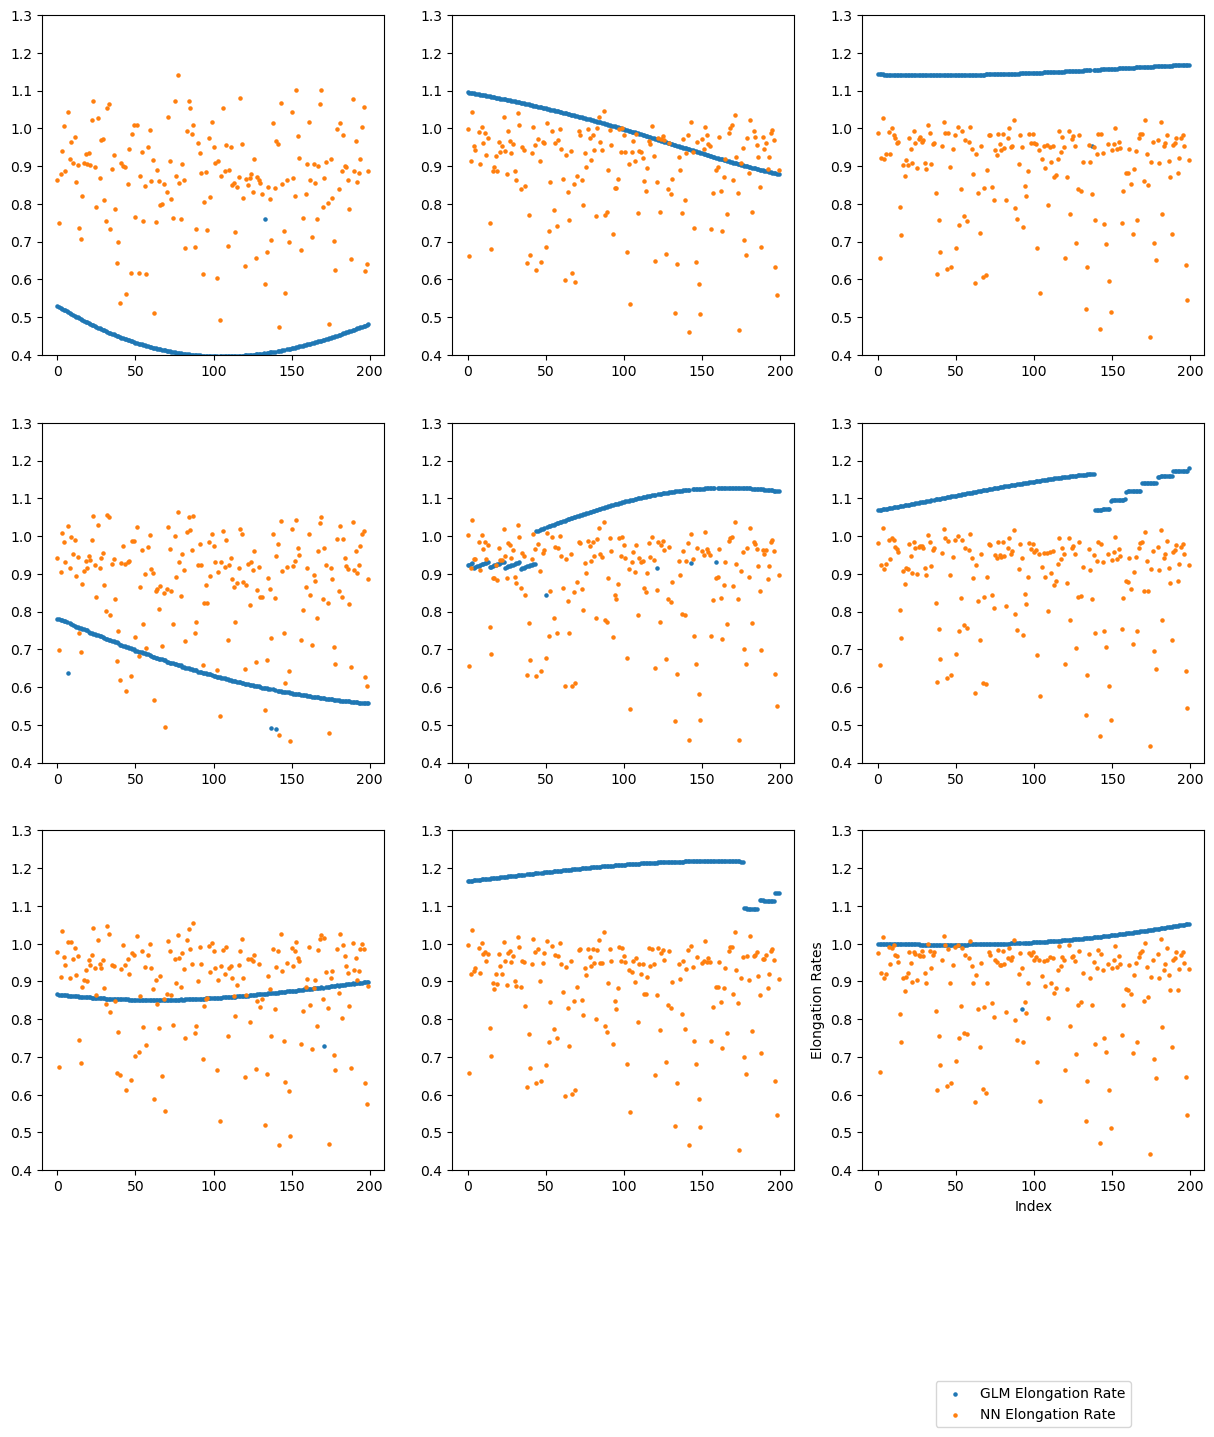

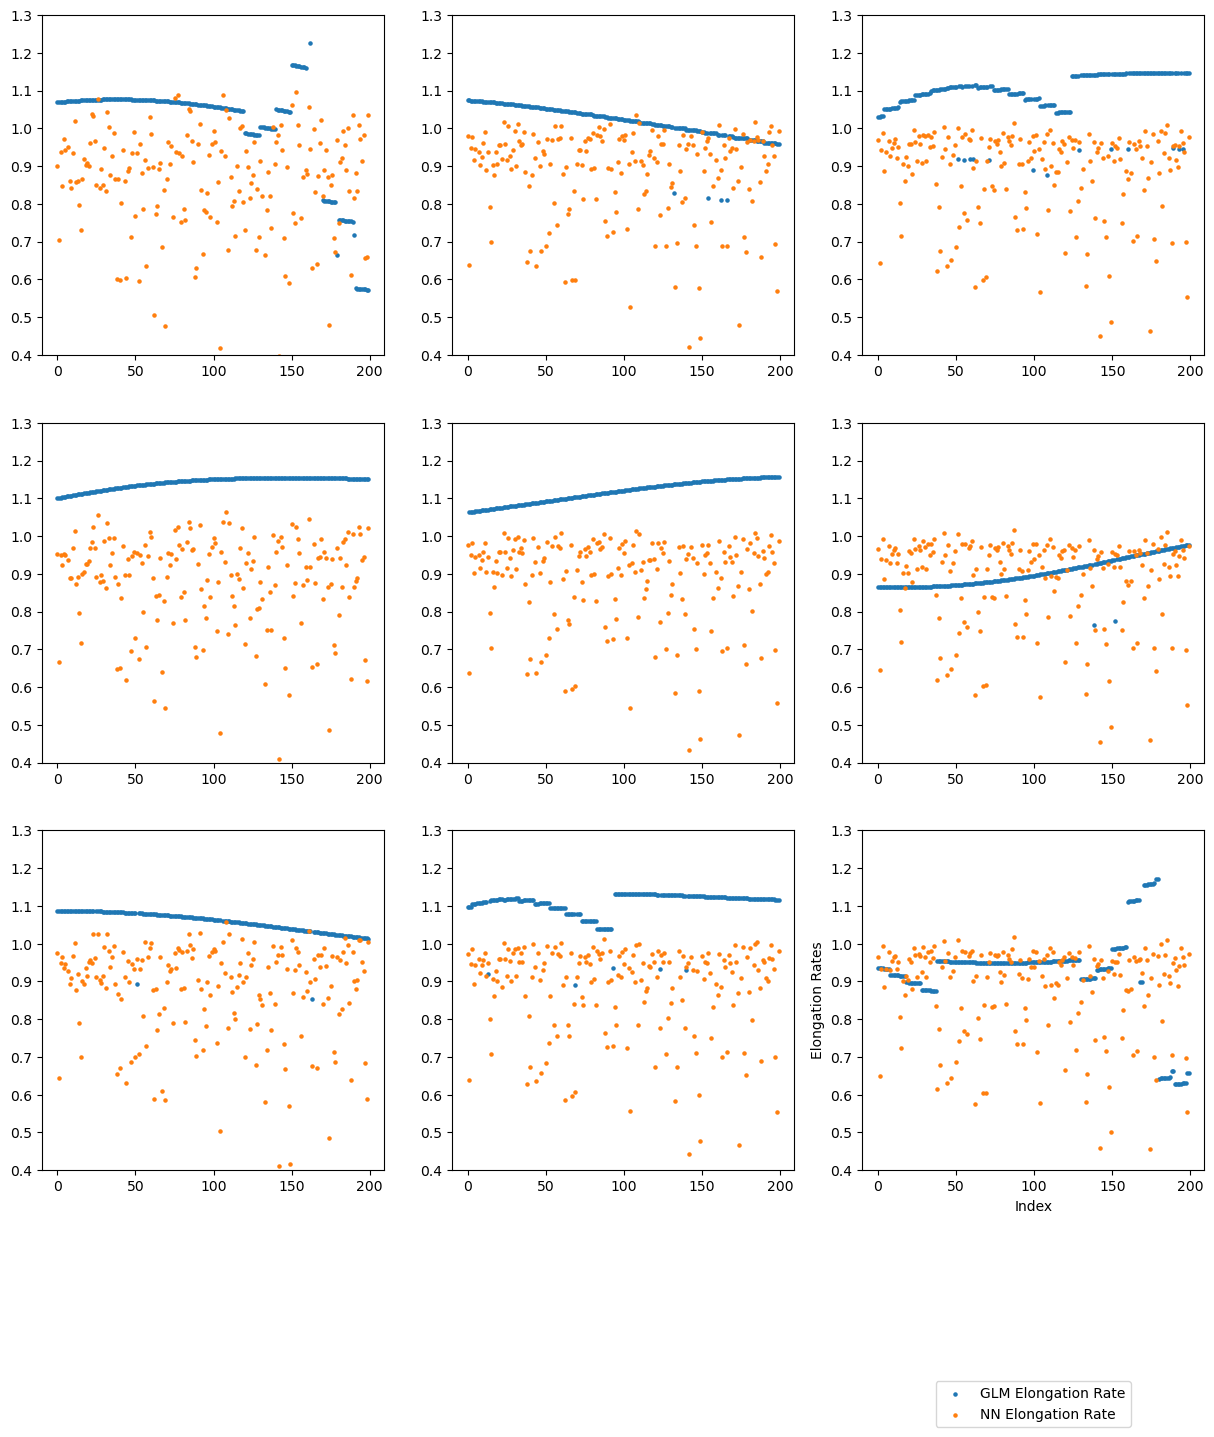

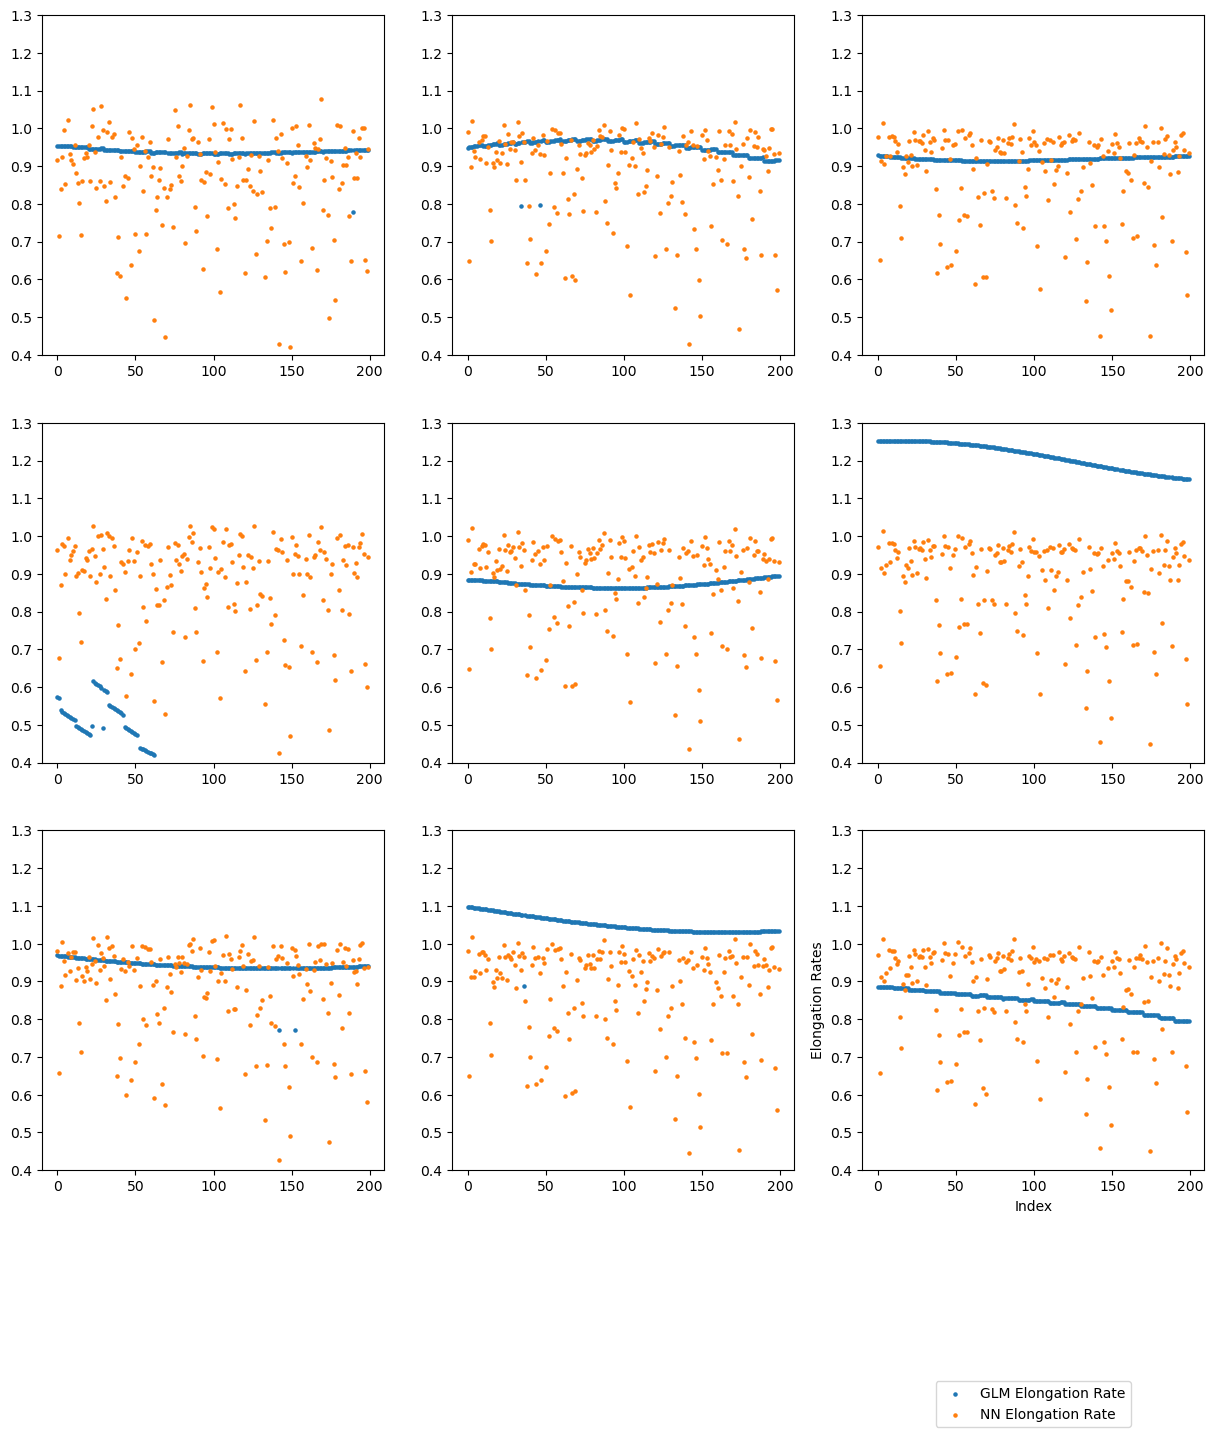

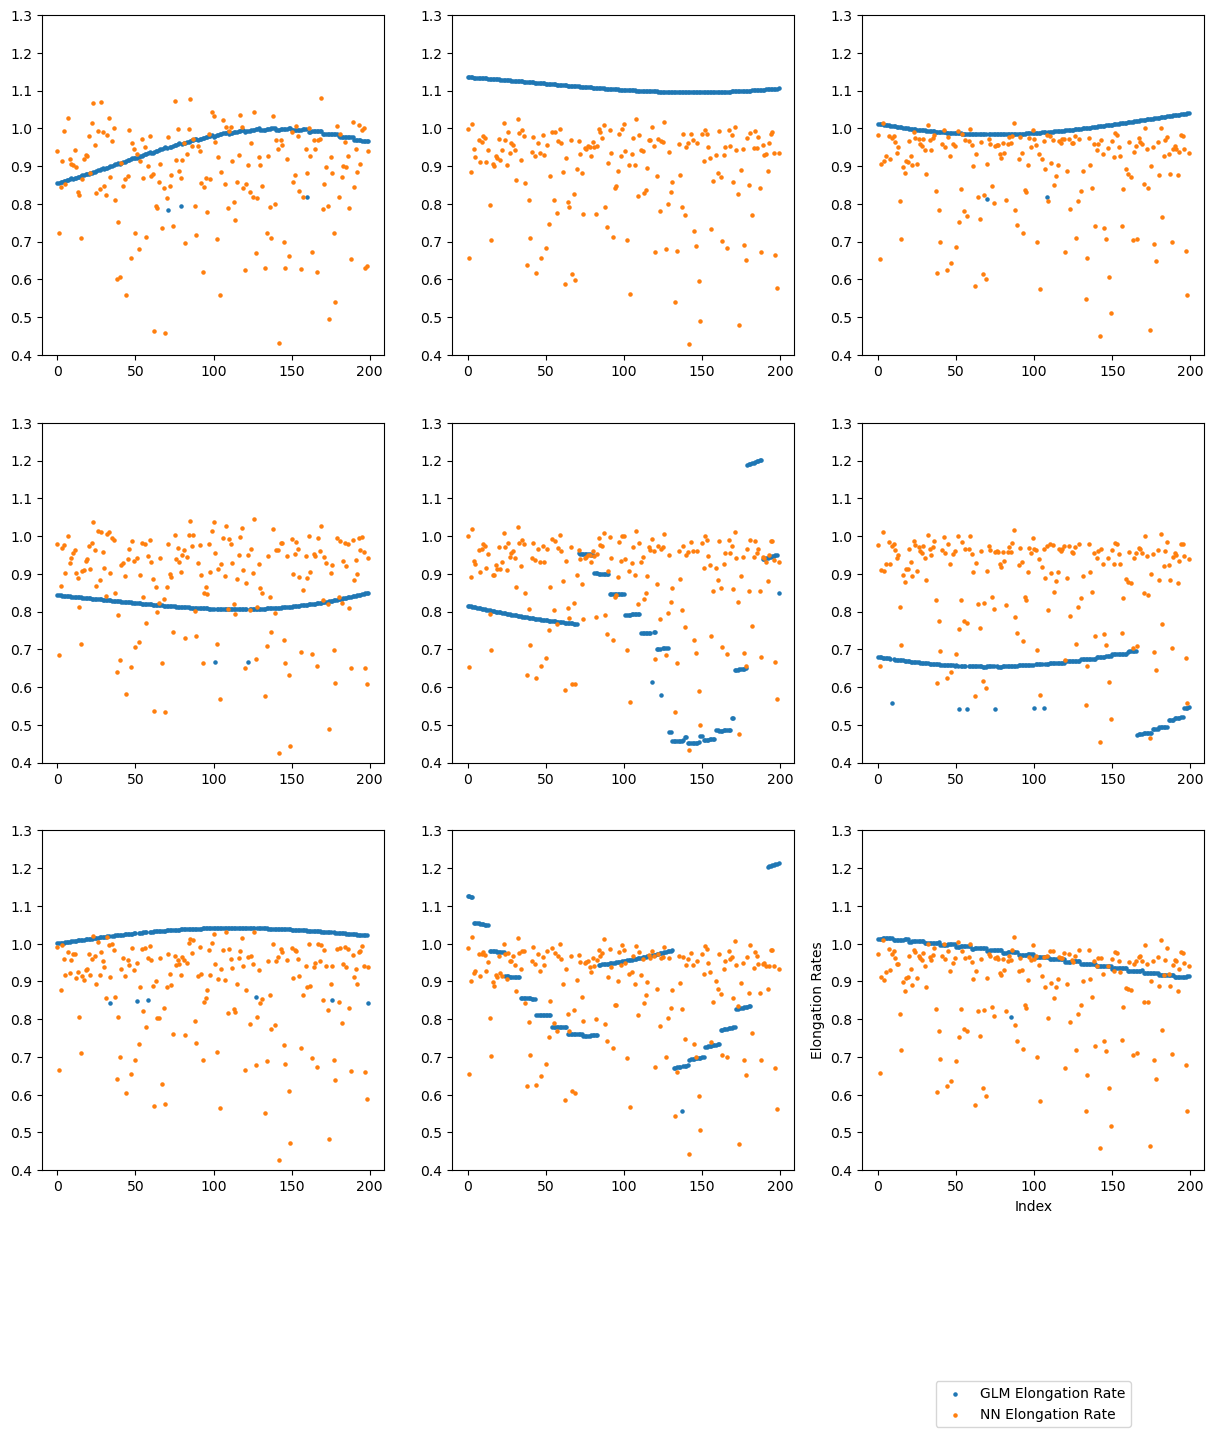

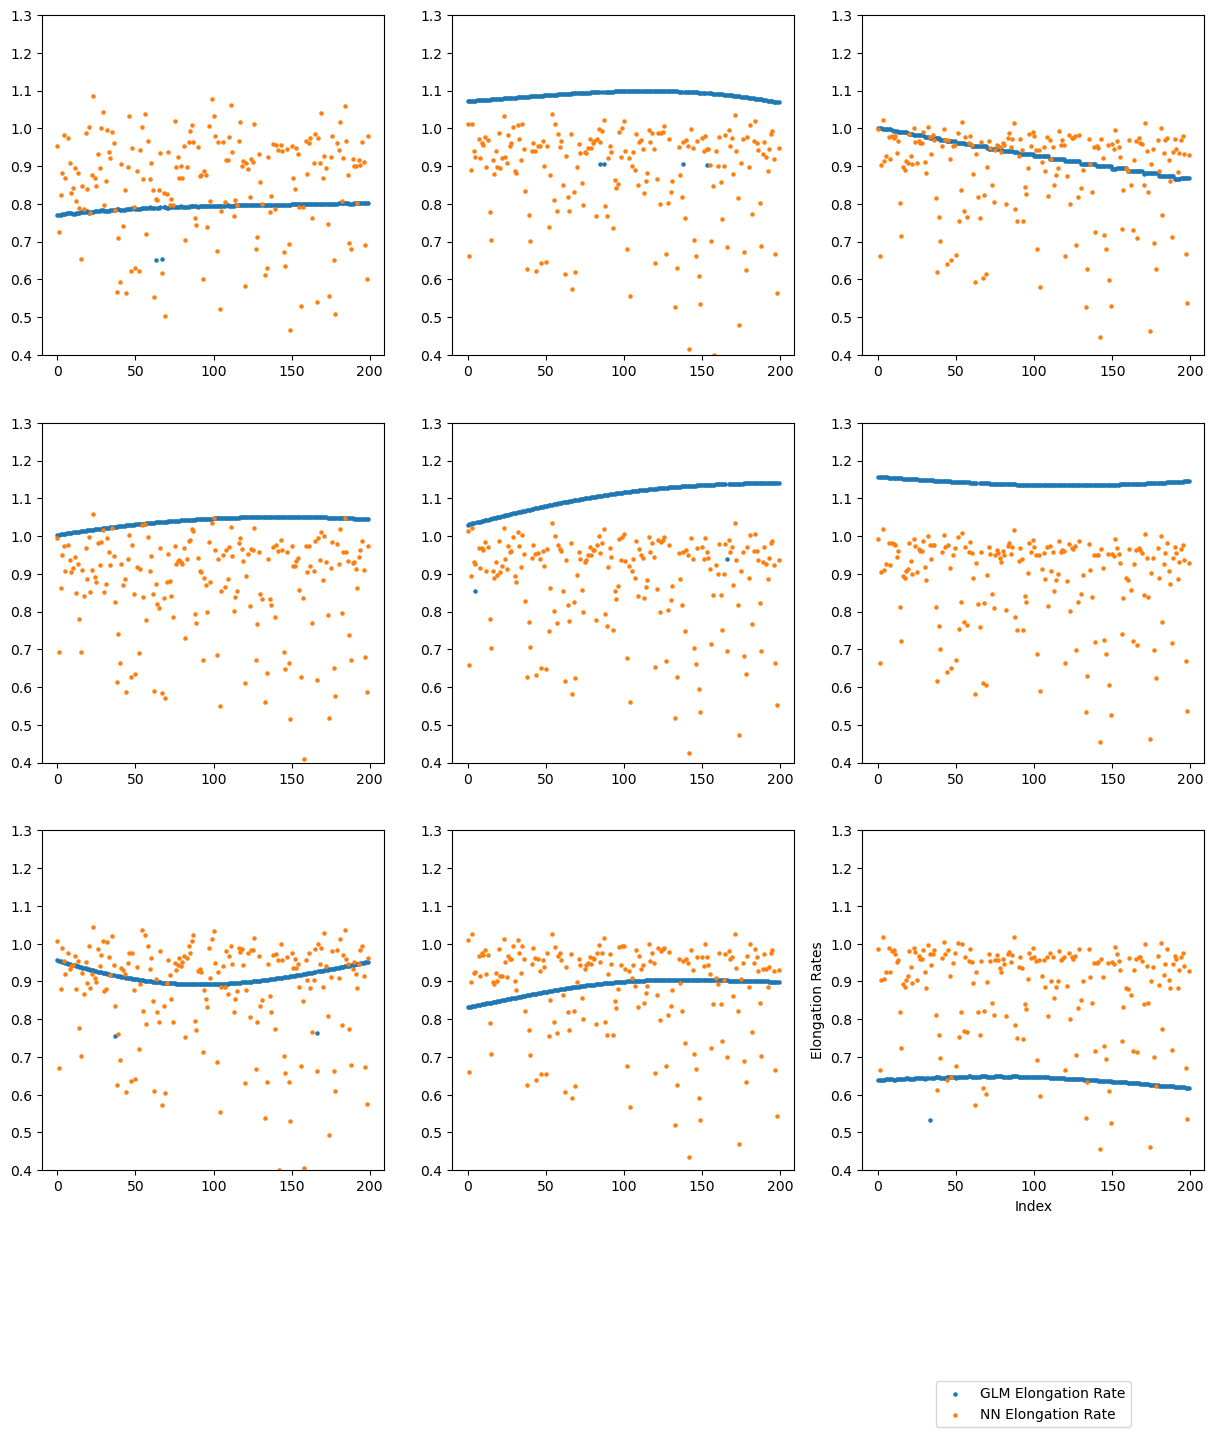

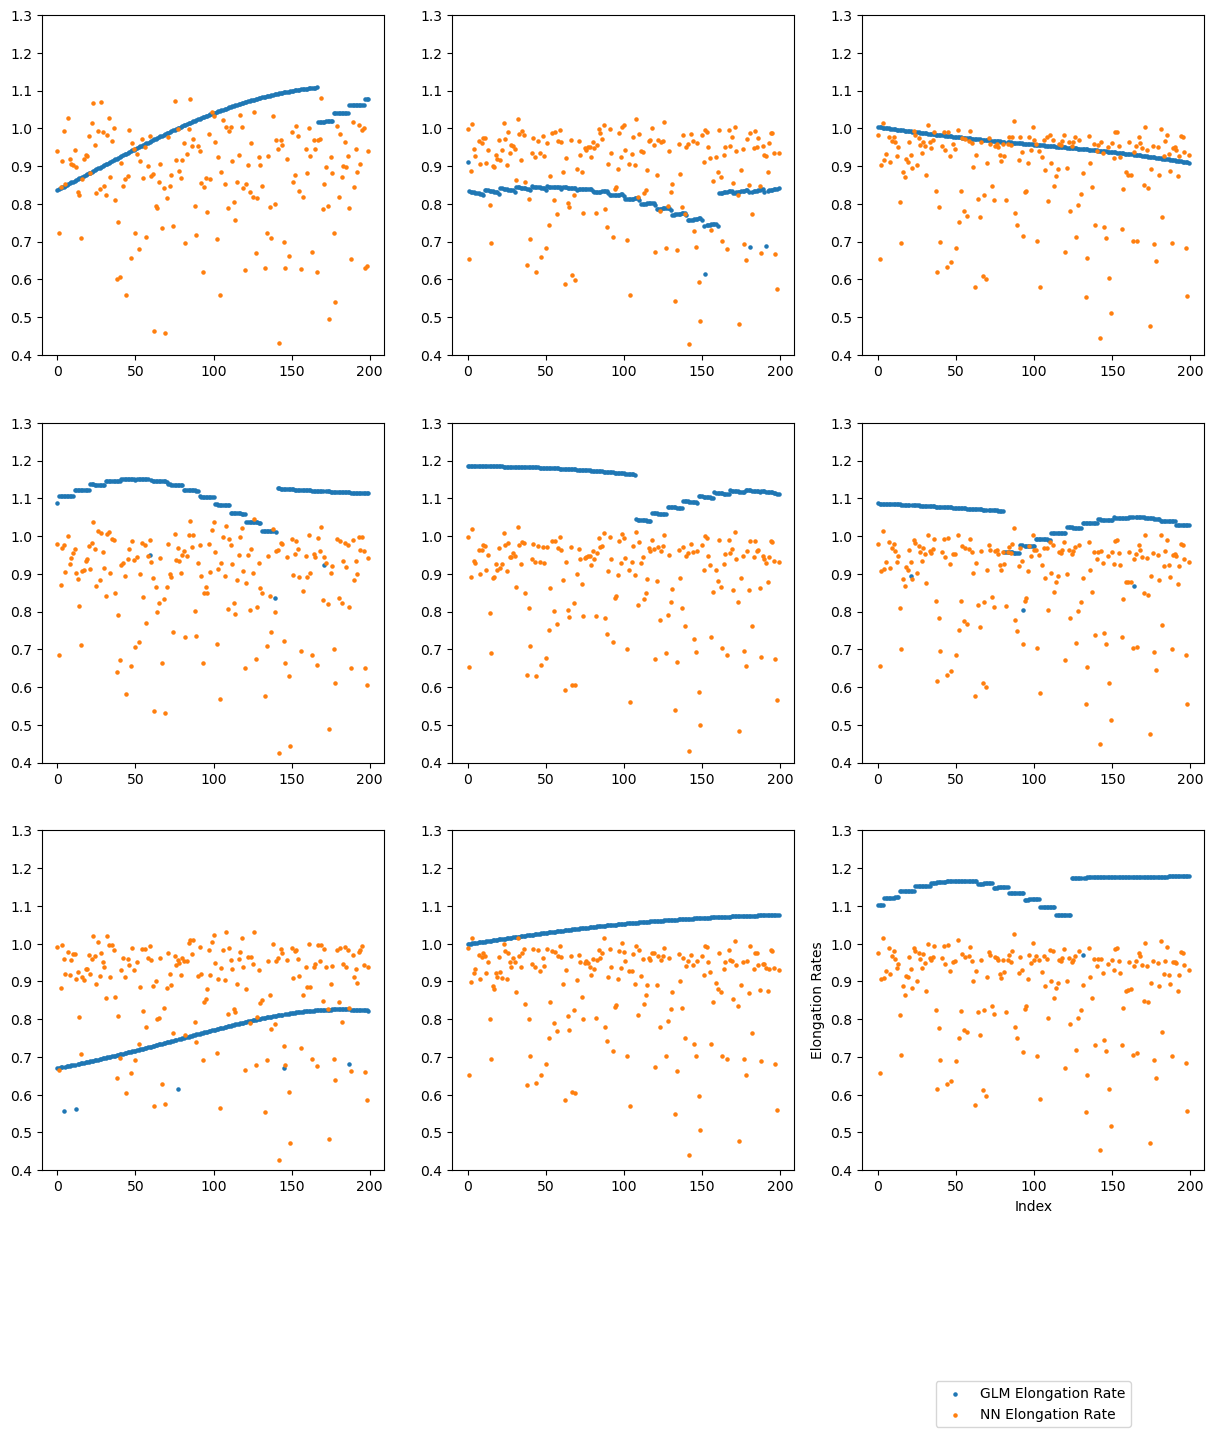

In [64]:
for batch in tstdl:
    outputs = model(batch['X_ji'])
    targets = batch['Z_ji']
    indices = range(len(targets[0]))

    fig, axs = plt.subplots(3, 3, figsize=(15,15))
    for i in range(3):
        for j in range(3):
            axs[i, j].scatter(indices, targets[i+j*3], s=5)
            axs[i, j].scatter(indices, outputs.detach().numpy()[i+j*3], s=5)
            axs[i, j].set_ylim(0.4, 1.3)

    plt.xlabel('Index')
    plt.ylabel('Elongation Rates')
    plt.legend(['GLM Elongation Rate', 'NN Elongation Rate'], loc='upper center', bbox_to_anchor=(0.5, -0.6))